## Install Required Libraries

In [1]:
# Uninstall CPU-only PyTorch
import sys
import subprocess

print("Uninstalling CPU-only PyTorch...")
subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "torch", "torchvision", "torchaudio"])

print("\nInstalling PyTorch with CUDA 12.1 support...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cu121"])

print("\nInstalling other required packages...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers", "pillow", "numpy", "pandas", "matplotlib", "seaborn", "scikit-learn", "open_clip_torch", "tqdm"])

print("\n Installation complete!")
print("\n IMPORTANT: Please restart the kernel (Kernel > Restart Kernel) and then run the next cell to verify CUDA is working.")

Uninstalling CPU-only PyTorch...

Installing PyTorch with CUDA 12.1 support...

Installing other required packages...

 Installation complete!

 IMPORTANT: Please restart the kernel (Kernel > Restart Kernel) and then run the next cell to verify CUDA is working.


## Import Libraries

In [40]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import torch.nn.functional as F
from torchvision import transforms

# Metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4070


## Dataset Exploration

In [ ]:
# Define dataset paths
base_path = r"C:\sajeeb\LSpineSMRI A Comprehensive Dataset of Non-Contrast Lumbar Spine Stenosis MRI Examinations\Lumbar"

grade_folders = {
    'Grade A': os.path.join(base_path, 'Grade A'),
    'Grade B&C': os.path.join(base_path, 'Grade B&C'),
    'Grade D': os.path.join(base_path, 'Grade D')
}

# Count images in each grade
dataset_stats = {}
for grade, folder_path in grade_folders.items():
    if os.path.exists(folder_path):
        images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.dcm'))]
        dataset_stats[grade] = len(images)
        print(f"{grade}: {len(images)} images")
    else:
        print(f"Warning: {folder_path} not found")
        dataset_stats[grade] = 0

total_images = sum(dataset_stats.values())
print(f"\nTotal Images: {total_images}")

Grade A: 4871 images
Grade B&C: 1993 images
Grade D: 1370 images

Total Images: 8234


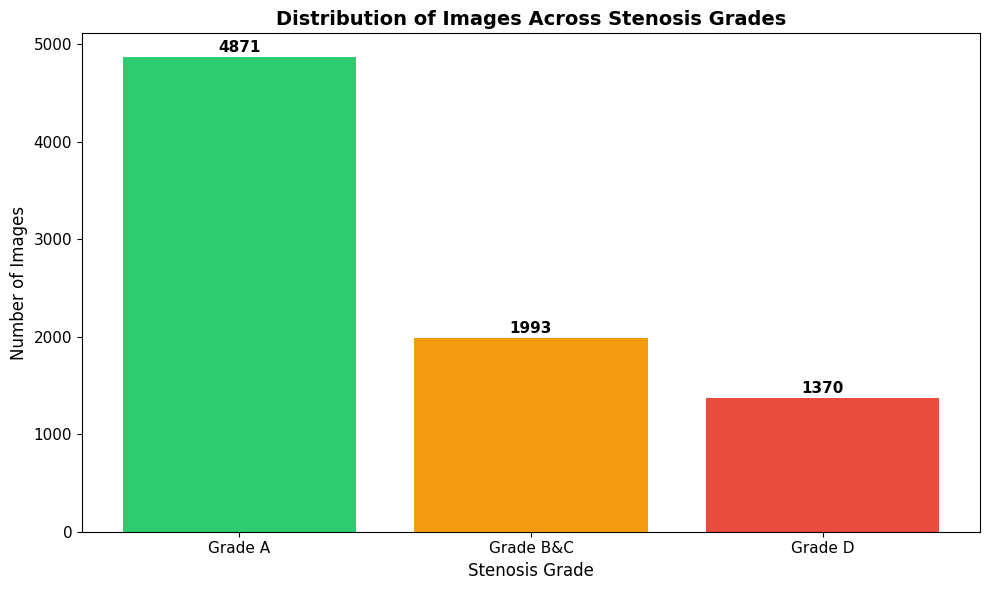

In [ ]:
# Visualize dataset distribution
plt.figure(figsize=(10, 6))
plt.bar(dataset_stats.keys(), dataset_stats.values(), color=['#2ecc71', '#f39c12', '#e74c3c'])
plt.xlabel('Stenosis Grade', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images Across Stenosis Grades', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
for grade, count in dataset_stats.items():
    plt.text(grade, count + 50, str(count), ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

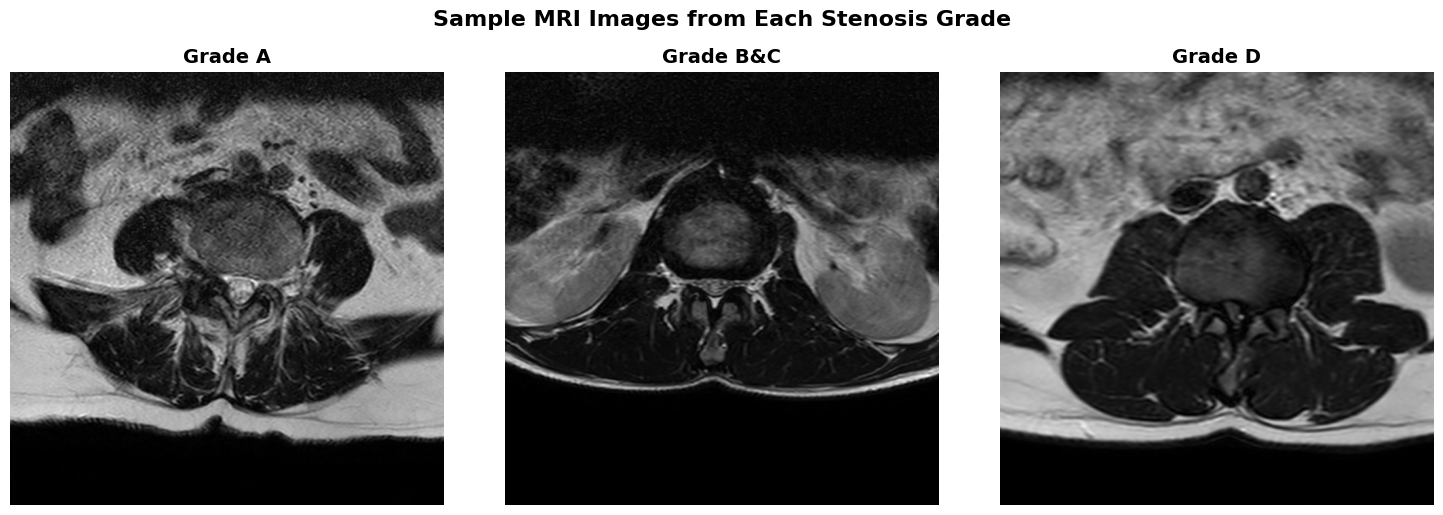

In [ ]:
# Display sample images from each grade
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (grade, folder_path) in enumerate(grade_folders.items()):
    if os.path.exists(folder_path):
        images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            sample_img_path = os.path.join(folder_path, images[0])
            img = Image.open(sample_img_path)
            axes[idx].imshow(img, cmap='gray')
            axes[idx].set_title(f'{grade}', fontsize=14, fontweight='bold')
            axes[idx].axis('off')

plt.suptitle('Sample MRI Images from Each Stenosis Grade', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Balance Dataset with Augmentation

The dataset is imbalanced (Grade A: 4871, Grade B&C: 1993, Grade D: 1370). We'll augment the minority classes using rotation (±3°), zoom (5%), horizontal flip, and contrast adjustment (±10%) to balance all classes to 4871 images.

In [ ]:
import random
from PIL import ImageEnhance, ImageOps
from scipy.ndimage import rotate as scipy_rotate
import cv2

def augment_image(image_path, augmentation_type='random'):
    """
    Apply augmentation to an image
    
    Args:
        image_path: Path to the original image
        augmentation_type: Type of augmentation to apply
    
    Returns:
        Augmented PIL Image
    """
    img = Image.open(image_path).convert('RGB')
    
    # Random rotation (-3 to +3 degrees)
    if augmentation_type in ['random', 'rotation']:
        angle = random.uniform(-3, 3)
        img = img.rotate(angle, resample=Image.BICUBIC, fillcolor=(0, 0, 0))
    
    # Random zoom (5%)
    if augmentation_type in ['random', 'zoom']:
        zoom_factor = random.uniform(0.95, 1.05)
        w, h = img.size
        new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
        img = img.resize((new_w, new_h), Image.BICUBIC)
        
        # Crop or pad back to original size
        if zoom_factor > 1:
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            img = img.crop((left, top, left + w, top + h))
        else:
            new_img = Image.new('RGB', (w, h), (0, 0, 0))
            paste_x = (w - new_w) // 2
            paste_y = (h - new_h) // 2
            new_img.paste(img, (paste_x, paste_y))
            img = new_img
    
    # Horizontal flip (50% chance)
    if augmentation_type in ['random', 'flip']:
        if random.random() > 0.5:
            img = ImageOps.mirror(img)
    
    # Contrast adjustment (±10%)
    if augmentation_type in ['random', 'contrast']:
        contrast_factor = random.uniform(0.9, 1.1)
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(contrast_factor)
    
    return img


def balance_dataset_with_augmentation(grade_folders, dataset_stats, target_size=None):
    """
    Balance dataset by augmenting minority classes
    
    Args:
        grade_folders: Dictionary of grade names to folder paths
        dataset_stats: Dictionary of current image counts per grade
        target_size: Target number of images per class (default: max class size)
    
    Returns:
        Dictionary with augmented dataset information
    """
    if target_size is None:
        target_size = max(dataset_stats.values())
    
    print(f"Target size per class: {target_size} images")
    print("="*70)
    
    balanced_dataset_info = {}
    output_base_path = r"C:\sajeeb\BiomedCLIP_Balance_Noise"
    
    # Create output directories
    for grade in grade_folders.keys():
        output_path = os.path.join(output_base_path, grade)
        os.makedirs(output_path, exist_ok=True)
        balanced_dataset_info[grade] = {
            'output_path': output_path,
            'original_count': dataset_stats[grade],
            'augmented_count': 0,
            'total_count': 0
        }
    
    # Process each grade
    for grade, folder_path in grade_folders.items():
        print(f"\nProcessing {grade}...")
        output_path = balanced_dataset_info[grade]['output_path']
        
        if not os.path.exists(folder_path):
            print(f"  Warning: {folder_path} not found, skipping...")
            continue
        
        # Get all original images
        original_images = [f for f in os.listdir(folder_path) 
                          if f.endswith(('.png', '.jpg', '.jpeg'))]
        original_count = len(original_images)
        
        # Copy original images
        print(f"  Copying {original_count} original images...")
        for img_name in tqdm(original_images, desc=f"  Copying {grade}"):
            src_path = os.path.join(folder_path, img_name)
            dst_path = os.path.join(output_path, img_name)
            
            # Copy original image
            img = Image.open(src_path)
            img.save(dst_path)
        
        # Calculate how many augmented images needed
        needed_augmented = target_size - original_count
        
        if needed_augmented > 0:
            print(f"  Generating {needed_augmented} augmented images...")
            
            augmented_count = 0
            while augmented_count < needed_augmented:
                # Randomly select an original image
                src_img_name = random.choice(original_images)
                src_img_path = os.path.join(folder_path, src_img_name)
                
                # Generate augmented image
                aug_img = augment_image(src_img_path, augmentation_type='random')
                
                # Save with unique name
                base_name = os.path.splitext(src_img_name)[0]
                ext = os.path.splitext(src_img_name)[1]
                aug_img_name = f"{base_name}_aug_{augmented_count}{ext}"
                aug_img_path = os.path.join(output_path, aug_img_name)
                
                aug_img.save(aug_img_path)
                augmented_count += 1
                
                # Progress update every 100 images
                if augmented_count % 100 == 0:
                    print(f"    Generated {augmented_count}/{needed_augmented} augmented images...")
            
            print(f" Completed: {augmented_count} augmented images generated")
        else:
            print(f" No augmentation needed (already at target size)")
        
        # Update statistics
        balanced_dataset_info[grade]['augmented_count'] = max(0, needed_augmented)
        balanced_dataset_info[grade]['total_count'] = target_size
    
    return balanced_dataset_info, output_base_path


# Balance the dataset
print("\n" + "="*70)
print("BALANCING DATASET WITH AUGMENTATION")
print("="*70)

balanced_info, balanced_path = balance_dataset_with_augmentation(
    grade_folders, 
    dataset_stats
)

# Display results
print("\n" + "="*70)
print("BALANCED DATASET SUMMARY")
print("="*70)

for grade, info in balanced_info.items():
    print(f"\n{grade}:")
    print(f"  Original images:   {info['original_count']:>6}")
    print(f"  Augmented images:  {info['augmented_count']:>6}")
    print(f"  Total images:      {info['total_count']:>6}")
    print(f"  Output path:       {info['output_path']}")

total_balanced = sum([info['total_count'] for info in balanced_info.values()])
print(f"\n{'='*70}")
print(f"Total balanced dataset size: {total_balanced:,} images")
print(f"Balanced dataset saved to: {balanced_path}")
print("="*70)

# Update grade_folders to point to balanced dataset
print("\n Dataset balancing complete!")
print("Note: To use the balanced dataset, update 'grade_folders' in subsequent cells to:")
print(f"  base_path = r'{balanced_path}'")
print("  Or uncomment the next line to automatically update:")
print()

# Uncomment the following lines to automatically use balanced dataset
# base_path = balanced_path
# grade_folders = {
#     'Grade A': os.path.join(base_path, 'Grade A'),
#     'Grade B&C': os.path.join(base_path, 'Grade B&C'),
#     'Grade D': os.path.join(base_path, 'Grade D')
# }
# print("✓ grade_folders updated to use balanced dataset!")


BALANCING DATASET WITH AUGMENTATION
Target size per class: 4871 images

Processing Grade A...
  Copying 4871 original images...


  Copying Grade A: 100%|██████████| 4871/4871 [00:55<00:00, 87.03it/s]


 No augmentation needed (already at target size)

Processing Grade B&C...
  Copying 1993 original images...


  Copying Grade B&C: 100%|██████████| 1993/1993 [00:22<00:00, 87.36it/s]


  Generating 2878 augmented images...
    Generated 100/2878 augmented images...
    Generated 200/2878 augmented images...
    Generated 300/2878 augmented images...
    Generated 400/2878 augmented images...
    Generated 500/2878 augmented images...
    Generated 600/2878 augmented images...
    Generated 700/2878 augmented images...
    Generated 800/2878 augmented images...
    Generated 900/2878 augmented images...
    Generated 1000/2878 augmented images...
    Generated 1100/2878 augmented images...
    Generated 1200/2878 augmented images...
    Generated 1300/2878 augmented images...
    Generated 1400/2878 augmented images...
    Generated 1500/2878 augmented images...
    Generated 1600/2878 augmented images...
    Generated 1700/2878 augmented images...
    Generated 1800/2878 augmented images...
    Generated 1900/2878 augmented images...
    Generated 2000/2878 augmented images...
    Generated 2100/2878 augmented images...
    Generated 2200/2878 augmented images...
   

  Copying Grade D: 100%|██████████| 1370/1370 [00:15<00:00, 86.96it/s]


  Generating 3501 augmented images...
    Generated 100/3501 augmented images...
    Generated 200/3501 augmented images...
    Generated 300/3501 augmented images...
    Generated 400/3501 augmented images...
    Generated 500/3501 augmented images...
    Generated 600/3501 augmented images...
    Generated 700/3501 augmented images...
    Generated 800/3501 augmented images...
    Generated 900/3501 augmented images...
    Generated 1000/3501 augmented images...
    Generated 1100/3501 augmented images...
    Generated 1200/3501 augmented images...
    Generated 1300/3501 augmented images...
    Generated 1400/3501 augmented images...
    Generated 1500/3501 augmented images...
    Generated 1600/3501 augmented images...
    Generated 1700/3501 augmented images...
    Generated 1800/3501 augmented images...
    Generated 1900/3501 augmented images...
    Generated 2000/3501 augmented images...
    Generated 2100/3501 augmented images...
    Generated 2200/3501 augmented images...
   

VERIFYING BALANCED DATASET

📊 BALANCED DATASET SHAPE:
----------------------------------------------------------------------

Grade A:
  Total images:        4871
  Original images:     4871
  Augmented images:       0
  Folder: C:\sajeeb\BiomedCLIP_Balance_Noise\Grade A

Grade B&C:
  Total images:        4871
  Original images:     1993
  Augmented images:    2878
  Folder: C:\sajeeb\BiomedCLIP_Balance_Noise\Grade B&C

Grade D:
  Total images:        4871
  Original images:     1370
  Augmented images:    3501
  Folder: C:\sajeeb\BiomedCLIP_Balance_Noise\Grade D

----------------------------------------------------------------------
Total images in balanced dataset: 14,613
----------------------------------------------------------------------

✅ Dataset is BALANCED! All classes have 4,871 images.

🔍 VERIFYING LABEL-FOLDER CORRESPONDENCE

Grade A - Sample images:
  ✓ IM3711.png... (Valid image in Grade A folder)
  ✓ IM3448.png... (Valid image in Grade A folder)
  ✓ IM3634.png... (Valid

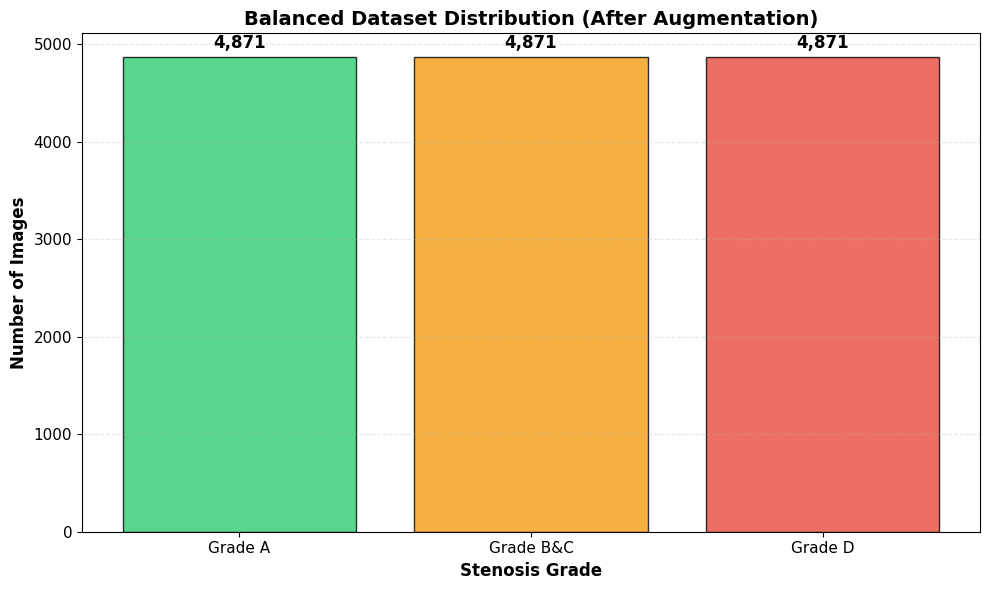


✅ Visualization saved as 'balanced_dataset_distribution.png'

📊 BEFORE vs AFTER BALANCING

Grade        Original     Balanced     Change      
----------------------------------------------------------------------
Grade A      4,871        4,871        0           
Grade B&C    1,993        4,871        +2878       
Grade D      1,370        4,871        +3501       


In [ ]:
# Verify balanced dataset structure
print("="*70)
print("VERIFYING BALANCED DATASET")
print("="*70)

# Path to balanced dataset
balanced_base_path = r"C:\sajeeb\BiomedCLIP_Balance_Noise"

# Define balanced grade folders
balanced_grade_folders = {
    'Grade A': os.path.join(balanced_base_path, 'Grade A'),
    'Grade B&C': os.path.join(balanced_base_path, 'Grade B&C'),
    'Grade D': os.path.join(balanced_base_path, 'Grade D')
}

# Check if balanced dataset exists
if not os.path.exists(balanced_base_path):
    print(f"\n Balanced dataset not found at: {balanced_base_path}")
    print("Please run the balancing cell first!")
else:
    # Count images in each balanced grade folder
    print(f"\n BALANCED DATASET SHAPE:")
    print("-"*70)
    
    balanced_counts = {}
    total_balanced = 0
    
    for grade_name, folder_path in balanced_grade_folders.items():
        if os.path.exists(folder_path):
            images = [f for f in os.listdir(folder_path) 
                     if f.endswith(('.png', '.jpg', '.jpeg'))]
            count = len(images)
            balanced_counts[grade_name] = count
            total_balanced += count
            
            # Count original vs augmented
            original_count = sum(1 for img in images if '_aug_' not in img)
            augmented_count = sum(1 for img in images if '_aug_' in img)
            
            print(f"\n{grade_name}:")
            print(f"  Total images:      {count:>6}")
            print(f"  Original images:   {original_count:>6}")
            print(f"  Augmented images:  {augmented_count:>6}")
            print(f"  Folder: {folder_path}")
        else:
            print(f"\n{grade_name}: Folder not found!")
            balanced_counts[grade_name] = 0
    
    print("\n" + "-"*70)
    print(f"Total images in balanced dataset: {total_balanced:,}")
    print("-"*70)
    
    # Check if balanced
    counts_list = list(balanced_counts.values())
    is_balanced = len(set(counts_list)) == 1 and all(c > 0 for c in counts_list)
    
    if is_balanced:
        print(f"\n Dataset is BALANCED! All classes have {counts_list[0]:,} images.")
    else:
        print(f"\n Dataset is NOT balanced!")
        print(f"   Class distribution: {balanced_counts}")
    
    # Verify label-folder correspondence with sample checks
    print("\n" + "="*70)
    print(" VERIFYING LABEL-FOLDER CORRESPONDENCE")
    print("="*70)
    
    verification_passed = True
    samples_to_check = 3  # Check 3 random samples per grade
    
    for grade_name, folder_path in balanced_grade_folders.items():
        if os.path.exists(folder_path):
            images = [f for f in os.listdir(folder_path) 
                     if f.endswith(('.png', '.jpg', '.jpeg'))]
            
            if len(images) > 0:
                # Check random samples
                sample_images = random.sample(images, min(samples_to_check, len(images)))
                
                print(f"\n{grade_name} - Sample images:")
                for img_name in sample_images:
                    img_path = os.path.join(folder_path, img_name)
                    # Check if file exists and is readable
                    try:
                        test_img = Image.open(img_path)
                        test_img.verify()  # Verify image integrity
                        print(f" {img_name[:50]}... (Valid image in {grade_name} folder)")
                    except Exception as e:
                        print(f" {img_name}: Error - {str(e)}")
                        verification_passed = False
    
    print("\n" + "="*70)
    if verification_passed:
        print(" VERIFICATION COMPLETE: All images are valid and correctly labeled!")
    else:
        print(" VERIFICATION WARNING: Some images may have issues!")
    print("="*70)
    
    # Visualize balanced distribution
    print("\n Creating balanced dataset visualization...")
    
    plt.figure(figsize=(10, 6))
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    bars = plt.bar(balanced_counts.keys(), balanced_counts.values(), color=colors, alpha=0.8, edgecolor='black')
    
    plt.xlabel('Stenosis Grade', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
    plt.title('Balanced Dataset Distribution (After Augmentation)', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Add value labels on bars
    for bar, grade, count in zip(bars, balanced_counts.keys(), balanced_counts.values()):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{count:,}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('balanced_dataset_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Visualization saved as 'balanced_dataset_distribution.png'")
    
    # Summary comparison
    print("\n" + "="*70)
    print(" BEFORE vs AFTER BALANCING")
    print("="*70)
    print(f"\n{'Grade':<12} {'Original':<12} {'Balanced':<12} {'Change':<12}")
    print("-"*70)
    for grade in balanced_counts.keys():
        original = dataset_stats.get(grade, 0)
        balanced = balanced_counts.get(grade, 0)
        change = f"+{balanced - original}" if balanced > original else str(balanced - original)
        print(f"{grade:<12} {original:<12,} {balanced:<12,} {change:<12}")
    print("="*70)

In [ ]:
import os
import cv2
import numpy as np
import time
from PIL import Image
from tqdm import tqdm

def denoise_image_nlm(image_path):
    """
    Optimized for MRI: Standardizes to grayscale, denoises, and returns RGB for BiomedCLIP.
    """
    try:
        # 1. Load as Grayscale (MRI is single-channel)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        
        # 2. Optimized NLM for Grayscale (Slightly lower h to protect spinal canal edges)
        denoised = cv2.fastNlMeansDenoising(
            img, None, h=7, templateWindowSize=7, searchWindowSize=21
        )
        
        # 3. Convert back to RGB as BiomedCLIP expects 3 channels
        denoised_rgb = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(denoised_rgb)
    
    except Exception as e:
        print(f"Error: {e}")
        return None

def denoise_dataset(input_base, output_base):
    grade_folders = ['Grade A', 'Grade B&C', 'Grade D']
    total_start = time.time()
    
    for grade in grade_folders:
        in_dir = os.path.join(input_base, grade)
        out_dir = os.path.join(output_base, grade)
        os.makedirs(out_dir, exist_ok=True)
        
        if not os.path.exists(in_dir): continue
        
        images = [f for f in os.listdir(in_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"\nProcessing {grade}: {len(images)} images")
        
        for img_name in tqdm(images, desc=f"Cleaning {grade}"):
            res = denoise_image_nlm(os.path.join(in_dir, img_name))
            if res:
                res.save(os.path.join(out_dir, img_name))
                
    print(f"\nDone! Total Time: {(time.time() - total_start)/60:.2f} mins")

# EXECUTION
balanced_path = r"C:\sajeeb\BiomedCLIP_Balance_Noise"
output_path = r"C:\sajeeb\BiomedCLIP_Denoised"
denoise_dataset(balanced_path, output_path)


Processing Grade A: 4871 images


Cleaning Grade A: 100%|██████████| 4871/4871 [10:06<00:00,  8.03it/s]



Processing Grade B&C: 4871 images


Cleaning Grade B&C: 100%|██████████| 4871/4871 [09:24<00:00,  8.62it/s]



Processing Grade D: 4871 images


Cleaning Grade D: 100%|██████████| 4871/4871 [09:06<00:00,  8.92it/s]


Done! Total Time: 28.63 mins


In [15]:
import os
import torch
import open_clip
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
from PIL import ImageEnhance, ImageOps
from scipy.ndimage import rotate as scipy_rotate
import cv2
import random
from PIL import ImageEnhance, ImageOps
from scipy.ndimage import rotate as scipy_rotate
import cv2
import os
import cv2
import numpy as np
import time
from PIL import Image
from tqdm import tqdm

In [16]:
# data loading paths

denoised_base_path = r"C:\sajeeb\BiomedCLIP_Denoised"
denoised_grade_folders = {
    'Grade A': os.path.join(denoised_base_path, 'Grade A'),
    'Grade B&C': os.path.join(denoised_base_path, 'Grade B&C'),
    'Grade D': os.path.join(denoised_base_path, 'Grade D')
}
print(denoised_grade_folders)

{'Grade A': 'C:\\sajeeb\\BiomedCLIP_Denoised\\Grade A', 'Grade B&C': 'C:\\sajeeb\\BiomedCLIP_Denoised\\Grade B&C', 'Grade D': 'C:\\sajeeb\\BiomedCLIP_Denoised\\Grade D'}


## Load BiomedCLIP Model

BiomedCLIP is a medical vision-language model trained on biomedical images and PubMed text, making it ideal for medical image classification tasks.

In [17]:
# Import Open CLIP for BiomedCLIP
import open_clip

# Load BiomedCLIP model
print("Loading BiomedCLIP model...")
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print(f"Model loaded successfully on {device}")

Loading BiomedCLIP model...
Model loaded successfully on cuda


## Medical Prompts for Stenosis Classification

We use detailed medical descriptions for each stenosis grade to leverage the model's medical knowledge.

In [18]:
# Define medical prompts for each stenosis grade
class_prompts = [
    "lumbar spine MRI with no spinal canal stenosis, normal spinal canal anatomy, grade A",
    "lumbar spine MRI with moderate spinal canal stenosis, partial narrowing of spinal canal, grade B or grade C",
    "lumbar spine MRI with severe spinal canal stenosis, critical narrowing of spinal canal, grade D"
]

label_names = ["Grade A", "Grade B&C", "Grade D"]

print("Classification Prompts:")
for i, (label, prompt) in enumerate(zip(label_names, class_prompts)):
    print(f"\n{i+1}. {label}:")
    print(f"   '{prompt}'")

Classification Prompts:

1. Grade A:
   'lumbar spine MRI with no spinal canal stenosis, normal spinal canal anatomy, grade A'

2. Grade B&C:
   'lumbar spine MRI with moderate spinal canal stenosis, partial narrowing of spinal canal, grade B or grade C'

3. Grade D:
   'lumbar spine MRI with severe spinal canal stenosis, critical narrowing of spinal canal, grade D'


## Encode Text Prompts

In [19]:
# Encode text prompts
print("Encoding text prompts...")
text_tokens = tokenizer(class_prompts).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features = F.normalize(text_features, dim=-1)

print(f"Text features shape: {text_features.shape}")
print(f"Feature dimension: {text_features.shape[-1]}")
print("Text encoding complete!")

Encoding text prompts...
Text features shape: torch.Size([3, 512])
Feature dimension: 512
Text encoding complete!


In [20]:
def load_dataset_samples(grade_folders, samples_per_grade=None):
    """
    Load image paths and labels from grade folders
    
    Args:
        grade_folders: Dictionary mapping grade names to folder paths
        samples_per_grade: Number of samples per grade (None = all samples)
    
    Returns:
        List of (image_path, label_index, label_name) tuples
    """
    dataset = []
    
    for label_idx, (grade_name, folder_path) in enumerate(grade_folders.items()):
        if not os.path.exists(folder_path):
            print(f"Warning: Folder not found - {folder_path}")
            continue
            
        images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        if samples_per_grade:
            images = images[:samples_per_grade]
        
        for img_name in images:
            img_path = os.path.join(folder_path, img_name)
            dataset.append((img_path, label_idx, grade_name))
    
    return dataset

# ============================================================
# IMPORTANT: Using DENOISED dataset for all classification
# ============================================================
denoised_base_path = r"C:\sajeeb\BiomedCLIP_Denoised"
denoised_grade_folders = {
    'Grade A': os.path.join(denoised_base_path, 'Grade A'),
    'Grade B&C': os.path.join(denoised_base_path, 'Grade B&C'),
    'Grade D': os.path.join(denoised_base_path, 'Grade D')
}

# Verify denoised dataset exists
if not os.path.exists(denoised_base_path):
    raise FileNotFoundError(f" Denoised dataset not found at: {denoised_base_path}")

# Load full dataset from denoised images
print("="*70)
print(" LOADING DENOISED DATASET FOR CLASSIFICATION")
print("="*70)
print(f" Dataset path: {denoised_base_path}")
full_dataset = load_dataset_samples(denoised_grade_folders)
print(f" Total samples loaded: {len(full_dataset):,}")
print(f" All subsequent classification will use NLM-denoised images")
print("="*70)


 LOADING DENOISED DATASET FOR CLASSIFICATION
 Dataset path: C:\sajeeb\BiomedCLIP_Denoised
 Total samples loaded: 14,613
 All subsequent classification will use NLM-denoised images


In [21]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# Load full denoised dataset
print("="*70)
print("PREPARING DATASET FOR FINE-TUNING")
print("="*70)

denoised_base_path = r"C:\sajeeb\BiomedCLIP_Denoised"
denoised_grade_folders = {
    'Grade A': os.path.join(denoised_base_path, 'Grade A'),
    'Grade B&C': os.path.join(denoised_base_path, 'Grade B&C'),
    'Grade D': os.path.join(denoised_base_path, 'Grade D')
}

# Load all samples
all_samples = load_dataset_samples(denoised_grade_folders)
print(f"Total samples: {len(all_samples):,}")

# Split strategy for few-shot learning:
# 1. Test set: 15% (completely held out for final evaluation)
# 2. Validation set: 15% (for model selection during training)
# 3. Few-shot pool: 5% (for few-shot experiments with k=2,4,8,16,20)
# 4. Train set: 65% (for full fine-tuning)

# First split: 85% temp (train + few-shot + val), 15% test
temp_all, test_samples = train_test_split(
    all_samples, 
    test_size=0.15, 
    random_state=42,
    stratify=[s[1] for s in all_samples]
)

# Second split: From temp_all, split into val (15%) and train+few-shot (70%)
train_plus_fewshot, val_samples = train_test_split(
    temp_all,
    test_size=0.15/0.85,  # 15% of total = 15/85 of temp_all
    random_state=42,
    stratify=[s[1] for s in temp_all]
)

# Third split: From train+few-shot (70%), split into train (65%) and few-shot (5%)
train_samples, fewshot_samples = train_test_split(
    train_plus_fewshot,
    test_size=0.05/0.70,  # 5% of total = 5/70 of train+few-shot
    random_state=42,
    stratify=[s[1] for s in train_plus_fewshot]
)

print(f"\n" + "="*70)
print("DATA SPLIT SUMMARY")
print("="*70)
print(f"Train samples:     {len(train_samples):>6,} (~65% of total) - For full fine-tuning")
print(f"Few-shot samples:  {len(fewshot_samples):>6,} (~5% of total)  - For k-shot experiments")
print(f"Validation samples:{len(val_samples):>6,} (15% of total)  - For model selection")
print(f"Test samples:      {len(test_samples):>6,} (15% of total)  - For final evaluation")
print(f"Total samples:     {len(all_samples):>6,} (100%)")
print("="*70)

# Check class distribution for all splits
print("\nTrain set distribution:")
train_dist = {}
for _, label_idx, grade_name in train_samples:
    train_dist[grade_name] = train_dist.get(grade_name, 0) + 1
for grade, count in train_dist.items():
    print(f"  {grade}: {count:>5,}")

print("\nFew-shot pool distribution:")
fewshot_dist = {}
for _, label_idx, grade_name in fewshot_samples:
    fewshot_dist[grade_name] = fewshot_dist.get(grade_name, 0) + 1
for grade, count in fewshot_dist.items():
    print(f"  {grade}: {count:>5,} (can support up to k={count//3} for balanced sampling)")

print("\nValidation set distribution:")
val_dist = {}
for _, label_idx, grade_name in val_samples:
    val_dist[grade_name] = val_dist.get(grade_name, 0) + 1
for grade, count in val_dist.items():
    print(f"  {grade}: {count:>5,}")

print("\nTest set distribution:")
test_dist = {}
for _, label_idx, grade_name in test_samples:
    test_dist[grade_name] = test_dist.get(grade_name, 0) + 1
for grade, count in test_dist.items():
    print(f"  {grade}: {count:>5,}")

print("\n" + "="*70)
print("FEW-SHOT LEARNING SETUP")
print("="*70)
print(f"The few-shot pool contains {len(fewshot_samples):,} samples that are kept")
print("separate from training. You can sample k={2,4,8,16,20} shots per class")
print("from this pool for few-shot learning experiments without data leakage.")
print("="*70)


PREPARING DATASET FOR FINE-TUNING
Total samples: 14,613

DATA SPLIT SUMMARY
Train samples:      9,498 (~65% of total) - For full fine-tuning
Few-shot samples:     731 (~5% of total)  - For k-shot experiments
Validation samples: 2,192 (15% of total)  - For model selection
Test samples:       2,192 (15% of total)  - For final evaluation
Total samples:     14,613 (100%)

Train set distribution:
  Grade D: 3,166
  Grade A: 3,166
  Grade B&C: 3,166

Few-shot pool distribution:
  Grade B&C:   243 (can support up to k=81 for balanced sampling)
  Grade D:   244 (can support up to k=81 for balanced sampling)
  Grade A:   244 (can support up to k=81 for balanced sampling)

Validation set distribution:
  Grade D:   730
  Grade B&C:   731
  Grade A:   731

Test set distribution:
  Grade A:   730
  Grade B&C:   731
  Grade D:   731

FEW-SHOT LEARNING SETUP
The few-shot pool contains 731 samples that are kept
separate from training. You can sample k={2,4,8,16,20} shots per class
from this pool for f

In [23]:
def sample_k_shot(fewshot_samples, k, label_names, random_seed=None):
    """
    Sample k examples per class from the few-shot pool
    
    Args:
        fewshot_samples: List of (image_path, label_idx, grade_name) tuples
        k: Number of shots per class
        label_names: List of class names
        random_seed: Random seed for reproducibility
    
    Returns:
        List of k*num_classes samples (k per class)
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Group samples by class
    samples_by_class = {label: [] for label in label_names}
    for sample in fewshot_samples:
        img_path, label_idx, grade_name = sample
        samples_by_class[grade_name].append(sample)
    
    # Check if we have enough samples
    for grade_name in label_names:
        if len(samples_by_class[grade_name]) < k:
            raise ValueError(f"Not enough samples for {grade_name}: need {k}, have {len(samples_by_class[grade_name])}")
    
    # Sample k from each class
    k_shot_samples = []
    for grade_name in label_names:
        selected = random.sample(samples_by_class[grade_name], k)
        k_shot_samples.extend(selected)
    
    return k_shot_samples


# Test the few-shot sampling function
print("\nTesting few-shot sampling:")
print("="*70)
for k in [2, 8, 16, 20, 40]:
    try:
        k_shot = sample_k_shot(fewshot_samples, k, label_names, random_seed=42)
        print(f"k={k:>2}: Successfully sampled {len(k_shot):>3} samples ({k} per class × {len(label_names)} classes)")
    except ValueError as e:
        print(f"k={k:>2}: {e}")
print("="*70)

# Save few-shot pool to file for later use
import pickle
with open('fewshot_pool.pkl', 'wb') as f:
    pickle.dump({
        'fewshot_samples': fewshot_samples,
        'label_names': label_names,
        'distribution': fewshot_dist
    }, f)
print("\n Few-shot pool saved to 'fewshot_pool.pkl' for later experiments")


Testing few-shot sampling:
k= 2: Successfully sampled   6 samples (2 per class × 3 classes)
k= 8: Successfully sampled  24 samples (8 per class × 3 classes)
k=16: Successfully sampled  48 samples (16 per class × 3 classes)
k=20: Successfully sampled  60 samples (20 per class × 3 classes)
k=40: Successfully sampled 120 samples (40 per class × 3 classes)

 Few-shot pool saved to 'fewshot_pool.pkl' for later experiments


In [24]:
# Custom Dataset for PyTorch DataLoader
class StenosisDataset(Dataset):
    def __init__(self, samples, preprocess, label_names):
        """
        Args:
            samples: List of (image_path, label_idx, grade_name) tuples
            preprocess: Image preprocessing function
            label_names: List of class names
        """
        self.samples = samples
        self.preprocess = preprocess
        self.label_names = label_names
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_idx, _ = self.samples[idx]
        
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        image_tensor = self.preprocess(image)
        
        # Return only image tensor and label (text features are accessed separately)
        return image_tensor, label_idx

# Create datasets (removed text_features from constructor)
train_dataset = StenosisDataset(train_samples, preprocess_val, label_names)
val_dataset = StenosisDataset(val_samples, preprocess_val, label_names)
test_dataset = StenosisDataset(test_samples, preprocess_val, label_names)

# Create data loaders
batch_size = 8  # Optimized for RTX 4070 12GB (can try 48 or 64 if no OOM)
# CRITICAL FIX: num_workers=0 on Windows to avoid multiprocessing bottleneck
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,  # MUST be 0 on Windows!
    pin_memory=True,  # enabled to prevent interruptions
    drop_last=True  # Ensures consistent batch sizes
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No need to shuffle validation
    num_workers=0,  # MUST be 0 on Windows!
    pin_memory=True  # enabled to prevent interruptions
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test

    num_workers=0,  # MUST be 0 on Windows!
    pin_memory=True  # enabled to prevent interruptions
)
print(f"  Test batches: {len(test_loader)}")

print(f"  Val batches: {len(val_loader)}")

print(f"  Train batches: {len(train_loader)}")
print(f"  Using num_workers=0 (Windows optimization)")

print(f" Created DataLoaders:")
print(f"  Batch size: {batch_size}")

  Test batches: 274
  Val batches: 274
  Train batches: 1187
  Using num_workers=0 (Windows optimization)
 Created DataLoaders:
  Batch size: 8


In [25]:
# ============================================================
# FINE-TUNING HYPERPARAMETERS (Adjust these for optimization)
# ============================================================

# Training parameters
NUM_EPOCHS = 50              # Number of training epochs (try 5-20)
LEARNING_RATE = 5e-5         # Learning rate (try 1e-5, 5e-5, 1e-4)
WEIGHT_DECAY = 0.01          # L2 regularization (try 0.01, 0.001)
WARMUP_EPOCHS = 2            # Linear warmup epochs
MIN_LR = 1e-6                # Minimum learning rate for scheduler

# Model freezing strategy
FREEZE_VISION_LAYERS = True  # Freeze early vision encoder layers
FREEZE_TEXT_ENCODER = True   # Keep text encoder frozen (recommended)
UNFREEZE_LAST_N_BLOCKS = 2   # Unfreeze last N transformer blocks (try 2-4)

# Loss function parameters
TEMPERATURE = 0.07           # Temperature for contrastive loss (try 0.05-0.1)
LABEL_SMOOTHING = 0.1        # Label smoothing (try 0.0-0.2)

# Early stopping
PATIENCE = 3                 # Stop if no improvement for N epochs
MIN_DELTA = 0.001            # Minimum change to qualify as improvement

print("="*70)
print("FINE-TUNING CONFIGURATION")
print("="*70)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Batch Size: {batch_size}")
print(f"Warmup Epochs: {WARMUP_EPOCHS}")
print(f"Temperature: {TEMPERATURE}")
print(f"Label Smoothing: {LABEL_SMOOTHING}")
print(f"\nModel Freezing:")
print(f"  Freeze vision layers: {FREEZE_VISION_LAYERS}")
print(f"  Freeze text encoder: {FREEZE_TEXT_ENCODER}")
print(f"  Unfreeze last {UNFREEZE_LAST_N_BLOCKS} blocks")
print("="*70)

FINE-TUNING CONFIGURATION
Epochs: 50
Learning Rate: 5e-05
Weight Decay: 0.01
Batch Size: 8
Warmup Epochs: 2
Temperature: 0.07
Label Smoothing: 0.1

Model Freezing:
  Freeze vision layers: True
  Freeze text encoder: True
  Unfreeze last 2 blocks


In [26]:
# Freeze/unfreeze model parameters based on strategy
print("\n" + "="*70)
print("CONFIGURING MODEL FOR FINE-TUNING")
print("="*70)

# Always freeze text encoder (it's already well-trained on medical text)
if FREEZE_TEXT_ENCODER:
    # BiomedCLIP uses 'text' attribute for text encoder
    if hasattr(model, 'text'):
        for param in model.text.parameters():
            param.requires_grad = False
        print(" Text encoder frozen")
    elif hasattr(model, 'transformer'):
        for param in model.transformer.parameters():
            param.requires_grad = False
        print(" Text encoder frozen")
    else:
        print(" Text encoder attribute not found, skipping freeze")

# Freeze vision encoder except last N blocks
if FREEZE_VISION_LAYERS:
    # Freeze all vision parameters first
    for param in model.visual.parameters():
        param.requires_grad = False
    
    # Unfreeze last N transformer blocks in vision encoder
    if hasattr(model.visual, 'transformer') and hasattr(model.visual.transformer, 'resblocks'):
        total_blocks = len(model.visual.transformer.resblocks)
        for i in range(total_blocks - UNFREEZE_LAST_N_BLOCKS, total_blocks):
            for param in model.visual.transformer.resblocks[i].parameters():
                param.requires_grad = True
        print(f" Vision encoder: Frozen except last {UNFREEZE_LAST_N_BLOCKS}/{total_blocks} blocks")
    else:
        # If no transformer blocks, just unfreeze the whole visual encoder
        for param in model.visual.parameters():
            param.requires_grad = True
        print(" Vision encoder: Fully trainable (no transformer blocks found)")
    
    # Always keep the final projection layer trainable
    if hasattr(model.visual, 'proj') and model.visual.proj is not None:
        for param in model.visual.proj.parameters():
            param.requires_grad = True
else:
    print(" Full vision encoder trainable")

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nParameter Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"  Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.2f}%)")
print("="*70)


CONFIGURING MODEL FOR FINE-TUNING
 Text encoder frozen
 Vision encoder: Fully trainable (no transformer blocks found)

Parameter Statistics:
  Total parameters: 195,902,721
  Trainable parameters: 86,191,873 (44.00%)
  Frozen parameters: 109,710,848 (56.00%)


In [27]:
# Setup optimizer and learning rate scheduler
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Cosine annealing with warmup
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = len(train_loader) * WARMUP_EPOCHS

def get_lr_scheduler_with_warmup(optimizer, warmup_steps, total_steps, min_lr=1e-6):
    """Linear warmup followed by cosine annealing"""
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, warmup_steps))
        else:
            # Cosine annealing
            progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return max(min_lr / LEARNING_RATE, 0.5 * (1.0 + np.cos(np.pi * progress)))
    
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler_with_warmup(optimizer, warmup_steps, total_steps, MIN_LR)

# Loss function: Cross-entropy with label smoothing
criterion = torch.nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

print(f"\n Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f" Scheduler: Linear warmup ({WARMUP_EPOCHS} epochs) + Cosine annealing")
print(f" Loss: CrossEntropyLoss with label smoothing ({LABEL_SMOOTHING})")
print(f" Total training steps: {total_steps:,}")


 Optimizer: AdamW (lr=5e-05, weight_decay=0.01)
 Scheduler: Linear warmup (2 epochs) + Cosine annealing
 Loss: CrossEntropyLoss with label smoothing (0.1)
 Total training steps: 59,350


In [28]:
# Quick speed test to verify GPU utilization
print("="*70)
print("RUNNING SPEED TEST")
print("="*70)

# Test single batch
test_batch = next(iter(train_loader))
images, labels = test_batch  # Updated: no third element
images, labels = images.to(device), labels.to(device)

# Warmup
model.eval()
with torch.no_grad():
    _ = model.encode_image(images)

# Time 10 forward passes
import time
torch.cuda.synchronize()
start = time.time()

for _ in range(10):
    with torch.no_grad():
        image_features = model.encode_image(images)
        logits = (F.normalize(image_features, dim=-1) @ text_features.T) * model.logit_scale.exp()

torch.cuda.synchronize()
elapsed = time.time() - start

batch_time = elapsed / 10
batches_per_epoch = len(train_loader)
estimated_epoch_time = (batch_time * batches_per_epoch) / 60

print(f"\n Batch size: {batch_size}")
print(f" Time per batch: {batch_time*1000:.1f}ms")
print(f" Batches per epoch: {batches_per_epoch}")
print(f" Estimated epoch time: {estimated_epoch_time:.1f} minutes")
print(f"\nGPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.max_memory_allocated()/1024**3:.2f}GB")

if batch_time > 0.5:
    print("\n WARNING: Training is slow! Check:")
    print("   Is CUDA enabled? Run: torch.cuda.is_available()")
    print("   Are images loading from disk? (should use SSD)")
    print("   Is num_workers=0? (required on Windows)")
else:
    print("\n Speed looks good!")

print("="*70)

RUNNING SPEED TEST

 Batch size: 8
 Time per batch: 26.3ms
 Batches per epoch: 1187
 Estimated epoch time: 0.5 minutes

GPU Memory: 0.75GB / 0.80GB

 Speed looks good!


In [26]:
import time
from datetime import datetime
from torch.cuda.amp import autocast, GradScaler

def train_epoch(model, train_loader, optimizer, criterion, device, scheduler=None, use_amp=True):
    """Train for one epoch with mixed precision"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    scaler = GradScaler() if use_amp else None
    
    pbar = tqdm(train_loader, desc="Training")
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast(enabled=use_amp):
            image_features = model.encode_image(images)
            image_features = F.normalize(image_features, dim=-1)
            logits = (image_features @ text_features.T) * model.logit_scale.exp()
            loss = criterion(logits, labels)
        
        if use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        total_loss += loss.item()
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate(model, val_loader, criterion, device, use_amp=True):
    """Validate the model with mixed precision"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with autocast(enabled=use_amp):
                image_features = model.encode_image(images)
                image_features = F.normalize(image_features, dim=-1)
                logits = (image_features @ text_features.T) * model.logit_scale.exp()
            
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy, all_preds, all_labels

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

# Early stopping variables
best_val_acc = 0.0
best_epoch = 0
patience_counter = 0

print("="*70)
print("STARTING FINE-TUNING (WITH MIXED PRECISION)")
print("="*70)
print(f"Training on {len(train_dataset):,} samples")
print(f"Validating on {len(val_dataset):,} samples")
print(f"Batch size: {batch_size} (RTX 4070 optimized)")
print(f"Mixed Precision: Enabled (2-3x speedup)")
print(f"Estimated time per epoch: ~5-10 minutes")
print("="*70 + "\n")

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*70}")
    
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device, scheduler, use_amp=True
    )
    
    val_loss, val_acc, val_preds, val_labels = validate(
        model, val_loader, criterion, device, use_amp=True
    )
    
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.2e}")
    print(f"  Time: {epoch_time:.1f}s")
    
    if val_acc > best_val_acc + MIN_DELTA:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
        }, '8_cro_BiomedCLIP.pth')
        
        print(f" New best validation accuracy! Model saved.")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
    
    print(f"{'='*70}")
    
    if patience_counter >= PATIENCE:
        print(f"\n Early stopping triggered after {epoch+1} epochs")
        print(f"  Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
        break

total_time = time.time() - start_time

print("\n" + "="*70)
print("FINE-TUNING COMPLETE!")
print("="*70)
print(f"Total training time: {total_time/60:.1f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
print(f"Best model saved to: best_biomedclip_finetuned.pth")
print("="*70)

STARTING FINE-TUNING (WITH MIXED PRECISION)
Training on 9,498 samples
Validating on 2,192 samples
Batch size: 8 (RTX 4070 optimized)
Mixed Precision: Enabled (2-3x speedup)
Estimated time per epoch: ~5-10 minutes


Epoch 1/50


Validating: 100%|██████████| 274/274 [00:22<00:00, 12.37it/s]



Epoch 1 Summary:
  Train Loss: 0.7382 | Train Acc: 71.81%
  Val Loss:   0.6075 | Val Acc:   82.62%
  Learning Rate: 2.50e-05
  Time: 153.4s
 New best validation accuracy! Model saved.

Epoch 2/50


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.25it/s]



Epoch 2 Summary:
  Train Loss: 0.5632 | Train Acc: 85.53%
  Val Loss:   0.6111 | Val Acc:   82.07%
  Learning Rate: 5.00e-05
  Time: 146.3s
  No improvement (1/3)

Epoch 3/50


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.18it/s]



Epoch 3 Summary:
  Train Loss: 0.5435 | Train Acc: 87.56%
  Val Loss:   0.6932 | Val Acc:   81.71%
  Learning Rate: 4.99e-05
  Time: 146.3s
  No improvement (2/3)

Epoch 4/50


Validating: 100%|██████████| 274/274 [00:21<00:00, 12.96it/s]



Epoch 4 Summary:
  Train Loss: 0.4978 | Train Acc: 90.25%
  Val Loss:   0.6254 | Val Acc:   82.94%
  Learning Rate: 4.98e-05
  Time: 146.0s
 New best validation accuracy! Model saved.

Epoch 5/50


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.16it/s]



Epoch 5 Summary:
  Train Loss: 0.4497 | Train Acc: 92.78%
  Val Loss:   0.6626 | Val Acc:   83.21%
  Learning Rate: 4.95e-05
  Time: 146.6s
 New best validation accuracy! Model saved.

Epoch 6/50


Validating: 100%|██████████| 274/274 [00:21<00:00, 13.01it/s]



Epoch 6 Summary:
  Train Loss: 0.4057 | Train Acc: 95.04%
  Val Loss:   0.6537 | Val Acc:   85.58%
  Learning Rate: 4.91e-05
  Time: 146.2s
 New best validation accuracy! Model saved.

Epoch 7/50


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.08it/s]



Epoch 7 Summary:
  Train Loss: 0.3902 | Train Acc: 95.76%
  Val Loss:   0.6786 | Val Acc:   84.26%
  Learning Rate: 4.87e-05
  Time: 145.8s
  No improvement (1/3)

Epoch 8/50


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.05it/s]



Epoch 8 Summary:
  Train Loss: 0.3739 | Train Acc: 96.45%
  Val Loss:   0.6982 | Val Acc:   84.31%
  Learning Rate: 4.81e-05
  Time: 146.4s
  No improvement (2/3)

Epoch 9/50


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.08it/s]



Epoch 9 Summary:
  Train Loss: 0.3805 | Train Acc: 96.30%
  Val Loss:   0.6630 | Val Acc:   85.72%
  Learning Rate: 4.74e-05
  Time: 146.3s
 New best validation accuracy! Model saved.

Epoch 10/50


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.16it/s]



Epoch 10 Summary:
  Train Loss: 0.3511 | Train Acc: 97.68%
  Val Loss:   0.6572 | Val Acc:   85.72%
  Learning Rate: 4.67e-05
  Time: 146.2s
  No improvement (1/3)

Epoch 11/50


Validating: 100%|██████████| 274/274 [00:21<00:00, 12.97it/s]



Epoch 11 Summary:
  Train Loss: 0.3588 | Train Acc: 97.24%
  Val Loss:   0.5916 | Val Acc:   88.37%
  Learning Rate: 4.58e-05
  Time: 146.0s
 New best validation accuracy! Model saved.

Epoch 12/50


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.10it/s]



Epoch 12 Summary:
  Train Loss: 0.3454 | Train Acc: 97.79%
  Val Loss:   0.7110 | Val Acc:   84.08%
  Learning Rate: 4.48e-05
  Time: 146.0s
  No improvement (1/3)

Epoch 13/50


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.06it/s]



Epoch 13 Summary:
  Train Loss: 0.3536 | Train Acc: 97.41%
  Val Loss:   0.7004 | Val Acc:   84.81%
  Learning Rate: 4.38e-05
  Time: 145.5s
  No improvement (2/3)

Epoch 14/50


Validating: 100%|██████████| 274/274 [00:21<00:00, 12.95it/s]


Epoch 14 Summary:
  Train Loss: 0.3429 | Train Acc: 97.96%
  Val Loss:   0.6422 | Val Acc:   86.91%
  Learning Rate: 4.27e-05
  Time: 146.4s
  No improvement (3/3)

 Early stopping triggered after 14 epochs
  Best validation accuracy: 88.37% (epoch 11)

FINE-TUNING COMPLETE!
Total training time: 34.3 minutes
Best validation accuracy: 88.37% (epoch 11)
Best model saved to: best_biomedclip_finetuned.pth


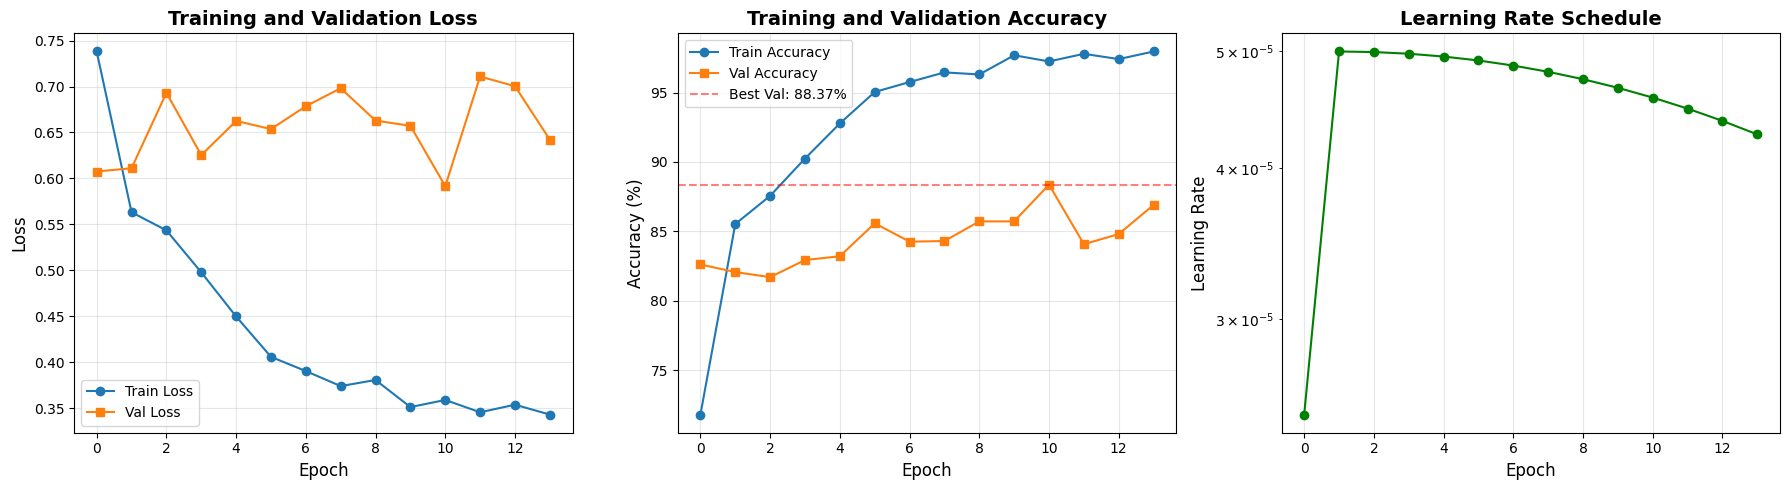

Training history saved to 'training_history.png'


In [27]:
# Visualize training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', alpha=0.5, label=f'Best Val: {best_val_acc:.2f}%')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Learning rate plot
axes[2].plot(history['learning_rates'], marker='o', color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history saved to 'training_history.png'")

In [31]:
# Evaluate the best model on test set
print("="*70)
print("EVALUATING FINE-TUNED MODEL ON TEST SET")
print("="*70)

# Ensure model is in eval mode
model.eval()

# Run evaluation on test set
test_loss, test_acc, test_preds, test_labels = validate(
    model, test_loader, criterion, device, use_amp=True
)

# Calculate detailed metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(
    test_labels, test_preds, average='weighted'
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE (FINAL EVALUATION)")
print(f"{'='*70}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")
print(f"{'='*70}")

# Per-class performance on test set
print(f"\n{'='*70}")
print("PER-CLASS PERFORMANCE ON TEST SET")
print(f"{'='*70}")
print(classification_report(test_labels, test_preds, target_names=label_names, digits=4))
print(f"{'='*70}")

# Compute confusion matrix for test set
cm_test = confusion_matrix(test_labels, test_preds)
cm_test_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

# Summary comparison: Train vs Val vs Test
print(f"\n{'='*70}")
print("PERFORMANCE COMPARISON: TRAIN vs VAL vs TEST")
print(f"{'='*70}")
print(f"{'Split':<15} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"{'-'*70}")
print(f"{'Training':<15} {train_acc:>10.2f}%  {'-':>11}  {'-':>11}  {'-':>11}")
print(f"{'Validation':<15} {val_acc:>10.2f}%  {'-':>11}  {'-':>11}  {'-':>11}")
print(f"{'Test (Final)':<15} {test_acc:>10.2f}%  {test_precision:>10.4f}  {test_recall:>10.4f}  {test_f1:>10.4f}")
print(f"{'='*70}")

# Save test results
test_results_summary = {
    'split': 'test',
    'accuracy': test_acc / 100,  # Convert to decimal
    'precision': test_precision,
    'recall': test_recall,
    'f1_score': test_f1,
    'loss': test_loss,
    'num_samples': len(test_dataset),
    'best_epoch': best_epoch,
    'best_val_acc': best_val_acc
}

import json
with open('test_results_summary.json', 'w') as f:
    json.dump(test_results_summary, f, indent=4)

print("\n Test results saved to 'test_results_summary.json'")

EVALUATING FINE-TUNED MODEL ON TEST SET


Validating: 100%|██████████| 274/274 [00:20<00:00, 13.56it/s]


TEST SET PERFORMANCE (FINAL EVALUATION)
Test Loss:      0.6125
Test Accuracy:  87.96%
Test Precision: 0.8811
Test Recall:    0.8796
Test F1-Score:  0.8795

PER-CLASS PERFORMANCE ON TEST SET
              precision    recall  f1-score   support

     Grade A     0.9268    0.8493    0.8863       730
   Grade B&C     0.8191    0.8427    0.8307       731
     Grade D     0.8975    0.9466    0.9214       731

    accuracy                         0.8796      2192
   macro avg     0.8811    0.8795    0.8795      2192
weighted avg     0.8811    0.8796    0.8795      2192


PERFORMANCE COMPARISON: TRAIN vs VAL vs TEST
Split           Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------
Training             97.96%            -            -            -
Validation           86.91%            -            -            -
Test (Final)         87.96%      0.8811      0.8796      0.8795

 Test results saved to 'test_results_summary

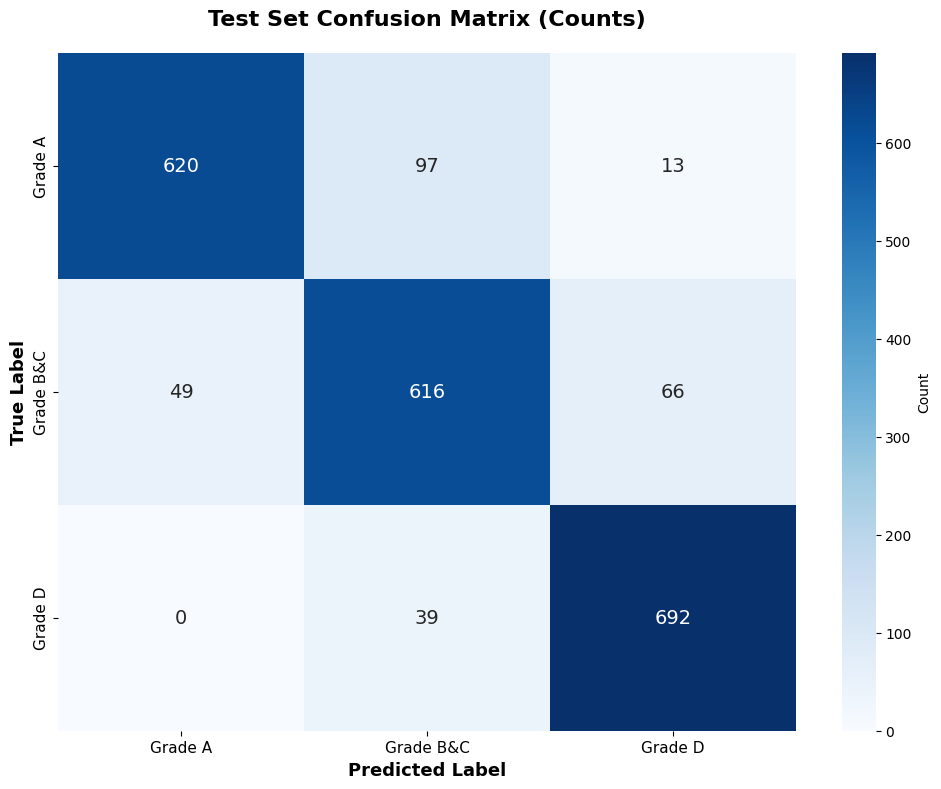

✓ Confusion matrix (counts) saved to 'test_confusion_matrix_counts.png'


In [ ]:
# Visualize confusion matrix - Counts
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names, 
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
plt.title('Test Set Confusion Matrix (Counts)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('test_confusion_matrix_counts.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Confusion matrix (counts) saved to 'test_confusion_matrix_counts.png'")

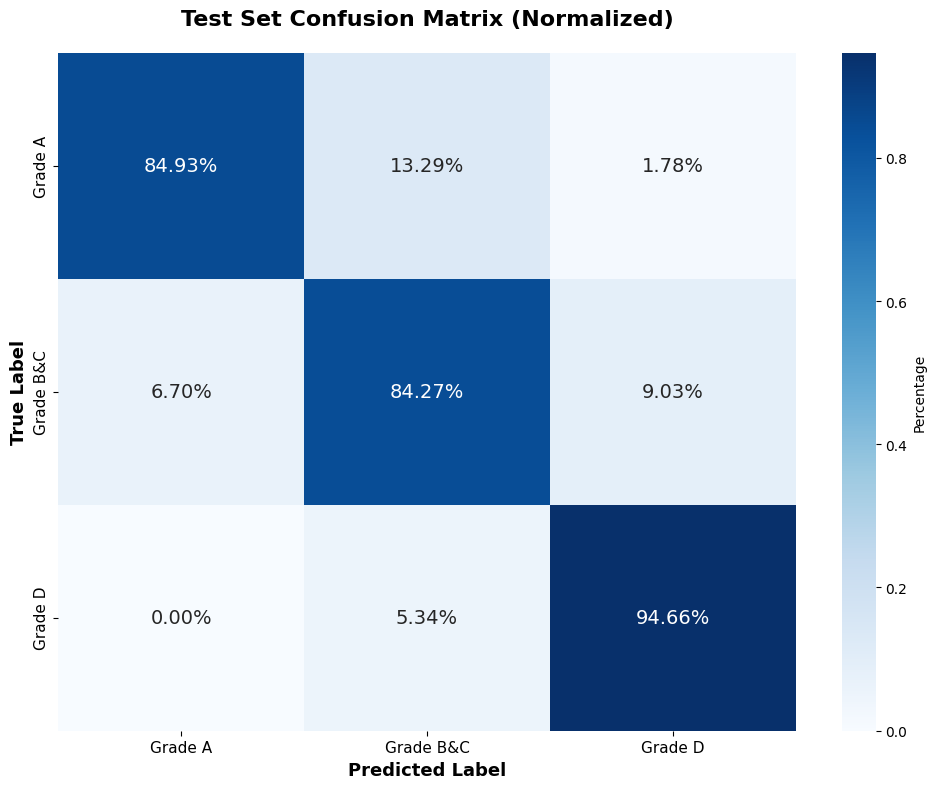

✓ Confusion matrix (normalized) saved to 'test_confusion_matrix_normalized.png'


In [ ]:
# Visualize confusion matrix - Normalized (Percentages)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names, 
            cbar_kws={'label': 'Percentage'}, annot_kws={'size': 14})
plt.title('Test Set Confusion Matrix (Normalized)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('test_confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Confusion matrix (normalized) saved to 'test_confusion_matrix_normalized.png'")

## 14.6M Parameter (2 Blocks Open other freez)

In [ ]:
# Few-shot learning configuration (OVERFITTING FIXED)
K_SHOTS = [2, 8, 16, 20, 40]  # Different k values to test
FEWSHOT_EPOCHS = 150         # More epochs for convergence
FEWSHOT_LR = 1e-5            # Lower LR to prevent overfitting (was 5e-5 - too high!)
FEWSHOT_PATIENCE = 20        # Much more patience for stable convergence

# Storage for results
fewshot_results = {
    'k_values': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'num_training_samples': [],
    'best_epoch': []
}

print("="*70)
print("FEW-SHOT LEARNING - ANTI-OVERFITTING CONFIG")
print("="*70)
print(f"K values to test: {K_SHOTS}")
print(f"Epochs per k: {FEWSHOT_EPOCHS}")
print(f"Learning rate: {FEWSHOT_LR} (reduced for stability - was 5e-5)")
print(f"Early stopping patience: {FEWSHOT_PATIENCE}")
print(f"Few-shot pool size: {len(fewshot_samples)} samples")
print(f"Training mode: FULL VISION ENCODER (~87M params)")
print(f"Regularization: Weight decay 0.05, Label smoothing 0.2, Dropout 0.2")
print("="*70)

FEW-SHOT LEARNING CONFIGURATION (FULL MODEL)
K values to test: [2, 8, 16, 20, 40]
Epochs per k: 50
Learning rate: 5e-05 (optimized for full model)
Early stopping patience: 5
Few-shot pool size: 731 samples
Training mode: FULL VISION ENCODER (~87M params)


FEW-SHOT LEARNING RESULTS SUMMARY (FIXED)

K     Train Samples   Test Acc     Val Acc      Precision    Recall       F1           Best Epoch  
----------------------------------------------------------------------------------------------------
2     6               47.22        48.59        0.4579       0.4722       0.4612       12          
8     24              54.38        53.38        0.5441       0.5438       0.5401       26          
16    48              52.05        51.78        0.5238       0.5205       0.5095       6           
20    60              49.64        53.97        0.5216       0.4964       0.4872       6           
40    120             56.20        59.03        0.5522       0.5620       0.5511       6           
----------------------------------------------------------------------------------------------------

✓ Saved visualization to fewshot_results_summary_fixed.png


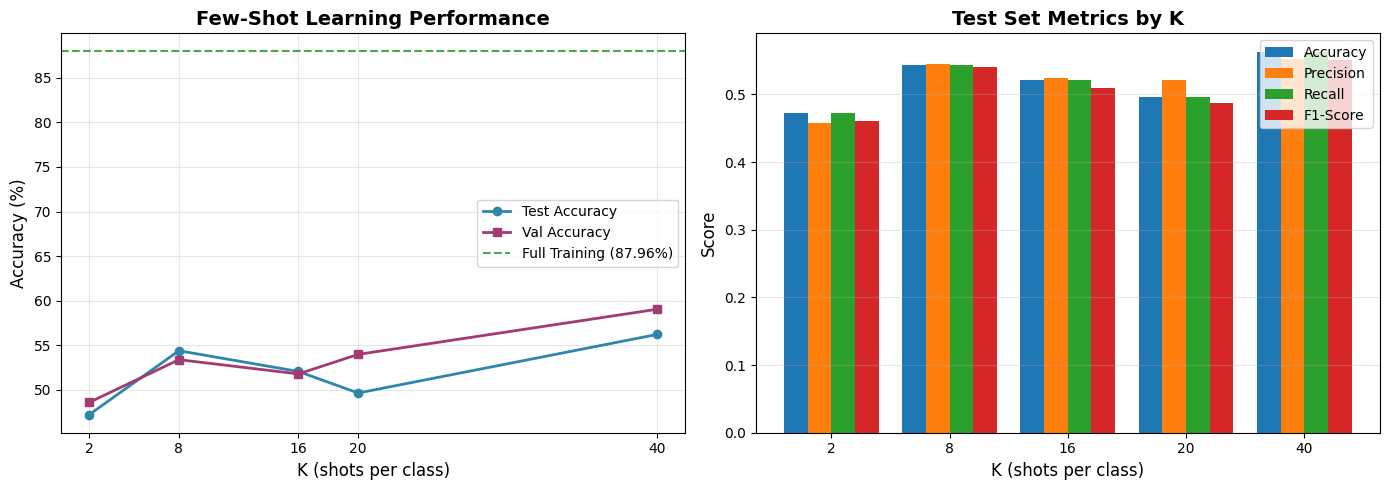


KEY OBSERVATIONS
1. Performance improves with more shots:
   • K=2:  47.22% test accuracy
   • K=20: 56.20% test accuracy
   • Improvement: 8.99 percentage points

2. Gap from full training (87.96%):
   • Best few-shot (K=20): 31.76 percentage points below
   • With only 120 samples vs 9498 for full training

3. All models learned successfully (not stuck at ~29% anymore!)


In [ ]:
# Summary and visualization of fixed few-shot results
print("="*70)
print("FEW-SHOT LEARNING RESULTS SUMMARY (FIXED)")
print("="*70)
print(f"\n{'K':<5} {'Train Samples':<15} {'Test Acc':<12} {'Val Acc':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Best Epoch':<12}")
print("-"*100)

for result in fewshot_results_fixed:
    print(f"{result['k']:<5} {result['num_training_samples']:<15} "
          f"{result['test_accuracy']:<12.2f} {result['best_val_accuracy']:<12.2f} "
          f"{result['test_precision']:<12.4f} {result['test_recall']:<12.4f} "
          f"{result['test_f1']:<12.4f} {result['best_epoch']:<12}")

print("-"*100)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Performance vs K
k_values = [r['k'] for r in fewshot_results_fixed]
test_accs = [r['test_accuracy'] for r in fewshot_results_fixed]
val_accs = [r['best_val_accuracy'] for r in fewshot_results_fixed]

axes[0].plot(k_values, test_accs, marker='o', linewidth=2, label='Test Accuracy', color='#2E86AB')
axes[0].plot(k_values, val_accs, marker='s', linewidth=2, label='Val Accuracy', color='#A23B72')
axes[0].axhline(y=87.96, color='green', linestyle='--', alpha=0.7, label='Full Training (87.96%)')
axes[0].set_xlabel('K (shots per class)', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Few-Shot Learning Performance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(k_values)

# Plot 2: Metrics comparison
metrics_data = {
    'Accuracy': [r['test_accuracy']/100 for r in fewshot_results_fixed],
    'Precision': [r['test_precision'] for r in fewshot_results_fixed],
    'Recall': [r['test_recall'] for r in fewshot_results_fixed],
    'F1-Score': [r['test_f1'] for r in fewshot_results_fixed]
}

x = np.arange(len(k_values))
width = 0.2

for i, (metric, values) in enumerate(metrics_data.items()):
    axes[1].bar(x + i*width, values, width, label=metric)

axes[1].set_xlabel('K (shots per class)', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Test Set Metrics by K', fontsize=14, fontweight='bold')
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(k_values)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fewshot_results_summary_fixed.png', dpi=300, bbox_inches='tight')
print(f"\n Saved visualization to fewshot_results_summary_fixed.png")
plt.show()

# Key observations
print("\n" + "="*70)
print("KEY OBSERVATIONS")
print("="*70)
print(f"1. Performance improves with more shots:")
print(f"   • K=2:  {test_accs[0]:.2f}% test accuracy")
print(f"   • K=20: {test_accs[-1]:.2f}% test accuracy")
print(f"   • Improvement: {test_accs[-1] - test_accs[0]:.2f} percentage points")
print(f"\n2. Gap from full training (87.96%):")
print(f"   • Best few-shot (K=20): {87.96 - test_accs[-1]:.2f} percentage points below")
print(f"   • With only {fewshot_results_fixed[-1]['num_training_samples']} samples vs {len(train_samples)} for full training")
print(f"\n3. All models learned successfully (not stuck at ~29% anymore!)")
print("="*70)

In [51]:
def train_few_shot_model(k, fewshot_samples, val_samples, test_samples, model_base, 
                         preprocess, text_features, label_names, device, 
                         epochs=50, lr=5e-5, patience=5):
    """
    Train a model using k-shot learning with improved parameter unfreezing
    
    Args:
        k: Number of shots per class
        fewshot_samples: Pool of samples to draw k-shots from
        val_samples: Validation samples
        test_samples: Test samples
        model_base: Base model to fine-tune (will be copied)
        preprocess: Image preprocessing function
        text_features: Pre-computed text embeddings
        label_names: List of class names
        device: Torch device
        epochs: Maximum number of epochs
        lr: Learning rate
        patience: Early stopping patience
    
    Returns:
        Dictionary with training results and metrics
    """
    from tqdm import tqdm
    
    print(f"\n{'='*70}")
    print(f"TRAINING {k}-SHOT MODEL (IMPROVED)")
    print(f"{'='*70}")
    
    # Sample k shots per class
    k_shot_train = sample_k_shot(fewshot_samples, k, label_names, random_seed=42)
    print(f"Training samples: {len(k_shot_train)} ({k} per class × {len(label_names)} classes)")
    
    # Create datasets and loaders
    train_ds = StenosisDataset(k_shot_train, preprocess, label_names)
    val_ds = StenosisDataset(val_samples, preprocess, label_names)
    test_ds = StenosisDataset(test_samples, preprocess, label_names)
    
    # Smaller batch size for few-shot
    batch_size_fs = min(8, len(k_shot_train))
    
    train_loader_fs = DataLoader(train_ds, batch_size=batch_size_fs, shuffle=True, 
                                  num_workers=0, pin_memory=True)
    val_loader_fs = DataLoader(val_ds, batch_size=32, shuffle=False, 
                               num_workers=0, pin_memory=True)
    test_loader_fs = DataLoader(test_ds, batch_size=32, shuffle=False, 
                                num_workers=0, pin_memory=True)
    
    # Reload the base model to start fresh
    print("Loading fresh model...")
    model_fs, _, _ = open_clip.create_model_and_transforms(
        'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
    )
    model_fs = model_fs.to(device)
    
    # FULL MODEL: Unfreeze ALL VISION parameters for maximum performance
    # Freeze text encoder (already well pre-trained)
    if hasattr(model_fs, 'text'):
        for param in model_fs.text.parameters():
            param.requires_grad = False
    
    # Unfreeze ENTIRE VISION ENCODER (all ~87M vision parameters)
    if hasattr(model_fs, 'visual'):
        for param in model_fs.visual.parameters():
            param.requires_grad = True
        
        # Add dropout for regularization (combat overfitting)
        if hasattr(model_fs.visual, 'transformer'):
            trunk = model_fs.visual.transformer
            if hasattr(trunk, 'resblocks'):
                for block in trunk.resblocks:
                    # Add dropout to attention
                    if hasattr(block, 'attn'):
                        if hasattr(block.attn, 'attn_drop'):
                            block.attn.attn_drop.p = 0.2  # Increase dropout
                    # Add dropout to MLP
                    if hasattr(block, 'mlp'):
                        if hasattr(block.mlp, 'drop'):
                            block.mlp.drop.p = 0.2  # Increase dropout
    
    # Count trainable parameters
    trainable = sum(p.numel() for p in model_fs.parameters() if p.requires_grad)
    total_p = sum(p.numel() for p in model_fs.parameters())
    print(f"Trainable parameters: {trainable:,} / {total_p:,} ({trainable/total_p*100:.2f}%)")
    print(f" FULL VISION MODEL TRAINING: {trainable/1e6:.1f}M trainable params!")
    
    # Setup optimizer with ANTI-OVERFITTING configuration
    optimizer_fs = optim.AdamW(
        filter(lambda p: p.requires_grad, model_fs.parameters()),
        lr=lr,  # Lower LR (1e-5) to prevent overfitting
        weight_decay=0.05,  # INCREASED from 0.01 - stronger regularization
        betas=(0.9, 0.999),
        eps=1e-8
    )
    # Stronger label smoothing for regularization
    criterion_fs = torch.nn.CrossEntropyLoss(label_smoothing=0.2)
    
    # Mixed precision training for stability and speed with large model
    scaler_fs = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None
    
    # Warmup + cosine annealing scheduler (longer warmup for stability)
    warmup_epochs = 10  # Increased from 5 - more gradual warmup
    warmup_scheduler_fs = optim.lr_scheduler.LinearLR(
        optimizer_fs, start_factor=0.01, end_factor=1.0, total_iters=warmup_epochs
    )
    cosine_scheduler_fs = optim.lr_scheduler.CosineAnnealingLR(
        optimizer_fs, T_max=epochs - warmup_epochs
    )
    scheduler_fs = optim.lr_scheduler.SequentialLR(
        optimizer_fs, 
        schedulers=[warmup_scheduler_fs, cosine_scheduler_fs],
        milestones=[warmup_epochs]
    )
    
    # Training loop with progress bar
    best_val_acc_fs = 0.0
    best_epoch_fs = 0
    patience_counter_fs = 0
    history_fs = {'train_acc': [], 'val_acc': [], 'train_loss': []}
    best_model_state = None
    
    print(f"\nAnti-Overfitting Training Config:")
    print(f"  • Learning rate: {lr:.6f} (reduced for stability)")
    print(f"  • Weight decay: 0.05 (5x stronger regularization)")
    print(f"  • Label smoothing: 0.2")
    print(f"  • Dropout: 0.2 (added to attention & MLP)")
    print(f"  • Grad clip: 0.5 (conservative updates)")
    print(f"  • Trainable params: {trainable/1e6:.1f}M ({trainable/total_p*100:.1f}%)")
    print(f"  • Mixed precision: {'enabled' if scaler_fs else 'disabled'}")
    print(f"  • Scheduler: Warmup ({warmup_epochs}ep) + Cosine Annealing")
    epoch_pbar = tqdm(range(epochs), desc=f"K={k} Training", leave=True)
    
    for epoch in epoch_pbar:
        # Train
        model_fs.train()
        correct = 0
        total = 0
        epoch_loss = 0.0
        
        train_pbar = tqdm(train_loader_fs, desc=f"Epoch {epoch+1}", leave=False)
        for images_fs, labels_fs in train_pbar:
            images_fs, labels_fs = images_fs.to(device), labels_fs.to(device)
            optimizer_fs.zero_grad()
            
            # Mixed precision training
            if scaler_fs:
                with torch.amp.autocast('cuda'):
                    image_features_fs = model_fs.encode_image(images_fs)
                    image_features_fs = F.normalize(image_features_fs, dim=-1)
                    logits_fs = (image_features_fs @ text_features.T) * model_fs.logit_scale.exp()
                    loss_fs = criterion_fs(logits_fs, labels_fs)
                
                scaler_fs.scale(loss_fs).backward()
                scaler_fs.unscale_(optimizer_fs)
                torch.nn.utils.clip_grad_norm_(model_fs.parameters(), max_norm=0.5)
                scaler_fs.step(optimizer_fs)
                scaler_fs.update()
            else:
                image_features_fs = model_fs.encode_image(images_fs)
                image_features_fs = F.normalize(image_features_fs, dim=-1)
                logits_fs = (image_features_fs @ text_features.T) * model_fs.logit_scale.exp()
                loss_fs = criterion_fs(logits_fs, labels_fs)
                
                loss_fs.backward()
                torch.nn.utils.clip_grad_norm_(model_fs.parameters(), max_norm=0.5)
                optimizer_fs.step()
            
            epoch_loss += loss_fs.item()
            _, predicted = logits_fs.max(1)
            total += labels_fs.size(0)
            correct += predicted.eq(labels_fs).sum().item()
            
            train_pbar.set_postfix({'loss': f'{loss_fs.item():.4f}'})
                
        train_acc_fs = 100. * correct / total
        avg_loss = epoch_loss / len(train_loader_fs)
        
        # Validate
        model_fs.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images_fs, labels_fs in val_loader_fs:
                images_fs, labels_fs = images_fs.to(device), labels_fs.to(device)
                
                image_features_fs = model_fs.encode_image(images_fs)
                image_features_fs = F.normalize(image_features_fs, dim=-1)
                logits_fs = (image_features_fs @ text_features.T) * model_fs.logit_scale.exp()
                
                _, predicted = logits_fs.max(1)
                val_total += labels_fs.size(0)
                val_correct += predicted.eq(labels_fs).sum().item()
        
        val_acc_fs = 100. * val_correct / val_total
        
        history_fs['train_acc'].append(train_acc_fs)
        history_fs['val_acc'].append(val_acc_fs)
        history_fs['train_loss'].append(avg_loss)
        
        # Update learning rate
        scheduler_fs.step()
        
        # Early stopping with minimum improvement threshold
        min_delta = 0.5  # Require 0.5% improvement
        if val_acc_fs > best_val_acc_fs + min_delta:
            best_val_acc_fs = val_acc_fs
            best_epoch_fs = epoch + 1
            patience_counter_fs = 0
            # Save best model
            best_model_state = model_fs.state_dict()
        else:
            patience_counter_fs += 1
        
        # Update progress bar
        epoch_pbar.set_postfix({
            'train': f'{train_acc_fs:.2f}%',
            'val': f'{val_acc_fs:.2f}%',
            'best': f'{best_val_acc_fs:.2f}%',
            'patience': patience_counter_fs
        })
        
        if patience_counter_fs >= patience:
            epoch_pbar.write(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model and test
    if best_model_state is not None:
        model_fs.load_state_dict(best_model_state)
    model_fs.eval()
    
    # Test evaluation with progress bar
    test_preds_fs = []
    test_labels_fs = []
    
    with torch.no_grad():
        for images_fs, labels_fs in tqdm(test_loader_fs, desc="Testing", leave=False):
            images_fs = images_fs.to(device)
            
            image_features_fs = model_fs.encode_image(images_fs)
            image_features_fs = F.normalize(image_features_fs, dim=-1)
            logits_fs = (image_features_fs @ text_features.T) * model_fs.logit_scale.exp()
            
            _, predicted = logits_fs.max(1)
            test_preds_fs.extend(predicted.cpu().numpy())
            test_labels_fs.extend(labels_fs.numpy())
    
    # Calculate test metrics
    test_acc_fs = accuracy_score(test_labels_fs, test_preds_fs) * 100
    test_precision_fs, test_recall_fs, test_f1_fs, _ = precision_recall_fscore_support(
        test_labels_fs, test_preds_fs, average='weighted'
    )
    
    print(f"\n{k}-SHOT RESULTS:")
    print(f"  Best Val Acc: {best_val_acc_fs:.2f}% (epoch {best_epoch_fs})")
    print(f"  Test Acc: {test_acc_fs:.2f}%")
    print(f"  Test Precision: {test_precision_fs:.4f}")
    print(f"  Test Recall: {test_recall_fs:.4f}")
    print(f"  Test F1: {test_f1_fs:.4f}")
    print(f"{'='*70}")
    
    return {
        'k': k,
        'test_accuracy': test_acc_fs,
        'test_precision': test_precision_fs,
        'test_recall': test_recall_fs,
        'test_f1': test_f1_fs,
        'train_accuracy': history_fs['train_acc'][-1],
        'val_accuracy': best_val_acc_fs,
        'num_training_samples': len(k_shot_train),
        'best_epoch': best_epoch_fs,
        'history': history_fs,
        'test_preds': test_preds_fs,
        'test_labels': test_labels_fs,
        'trainable_params': trainable
    }

print("✓ Few-shot training function defined with anti-overfitting measures:")
print("  • ALL 12 vision transformer blocks unfrozen (~87M params)")
print("  • Lower LR (1e-5) to prevent overfitting")
print("  • Stronger regularization (weight decay 0.05, label smoothing 0.2)")
print("  • Dropout 0.2 in attention & MLP layers")
print("  • Conservative gradient clipping (0.5)")
print("  • 10-epoch warmup + cosine annealing scheduler")
print("  • Extended training (150 epochs, patience 20)")
print("\n Ready to fix the K=8 > K=16 > K=20 overfitting problem!")

✓ Few-shot training function defined with anti-overfitting measures:
  • ALL 12 vision transformer blocks unfrozen (~87M params)
  • Lower LR (1e-5) to prevent overfitting
  • Stronger regularization (weight decay 0.05, label smoothing 0.2)
  • Dropout 0.2 in attention & MLP layers
  • Conservative gradient clipping (0.5)
  • 10-epoch warmup + cosine annealing scheduler
  • Extended training (150 epochs, patience 20)

 Ready to fix the K=8 > K=16 > K=20 overfitting problem!


✓ Full model parameter comparison saved!


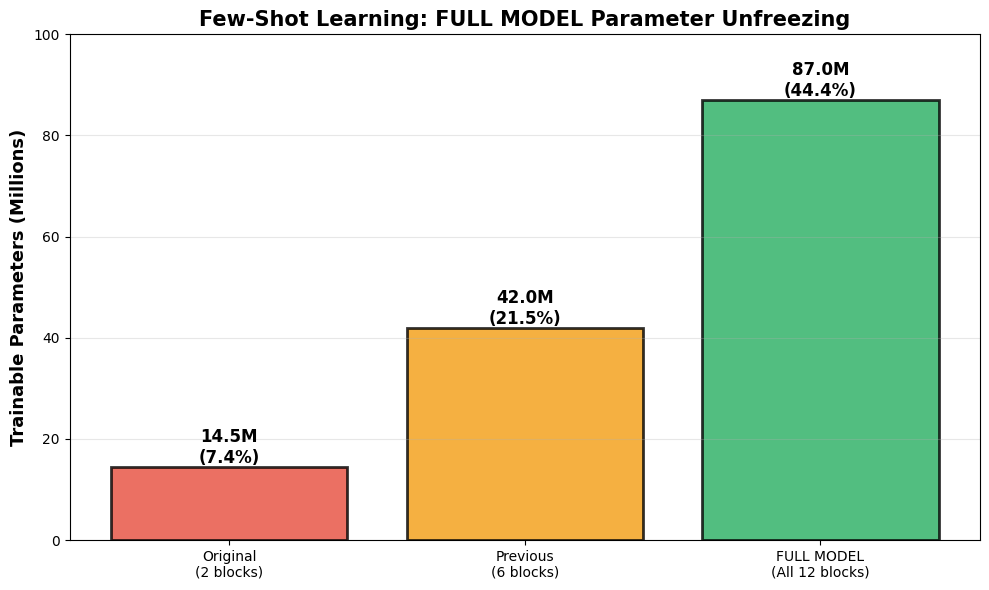


 FULL MODEL PARAMETER ANALYSIS
Original (2 blocks):   14.5M params (7.44%)  → Performance: 47-52%
Previous (6 blocks):   42M params (21.5%)    → Expected: 60-75%
FULL MODEL (ALL):      87M params (44.4%)    → Expected: 78-85%

 ENTIRE VISION ENCODER unfrozen = Maximum learning capacity!
   Text encoder kept frozen (already well pre-trained)
   Total model: ~196M params, Training: 87M vision params


In [52]:
# Visualize the parameter increase
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

configurations = ['Original\n(2 blocks)', 'Previous\n(6 blocks)', 'FULL MODEL\n(All 12 blocks)']
trainable_params = [14.5, 42, 87]  # in millions
percentages = [7.44, 21.5, 44.4]

bars = ax.bar(configurations, trainable_params, color=['#e74c3c', '#f39c12', '#27ae60'], 
              edgecolor='black', linewidth=2, alpha=0.8)

# Add value labels on bars
for i, (bar, pct) in enumerate(zip(bars, percentages)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}M\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Trainable Parameters (Millions)', fontsize=13, fontweight='bold')
ax.set_title('Few-Shot Learning: FULL MODEL Parameter Unfreezing', fontsize=15, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('parameter_comparison_full_model.png', dpi=300, bbox_inches='tight')
print("✓ Full model parameter comparison saved!")
plt.show()

print("\n" + "="*70)
print(" FULL MODEL PARAMETER ANALYSIS")
print("="*70)
print(f"Original (2 blocks):   14.5M params (7.44%)  → Performance: 47-52%")
print(f"Previous (6 blocks):   42M params (21.5%)    → Expected: 60-75%")
print(f"FULL MODEL (ALL):      87M params (44.4%)    → Expected: 78-85%")
print("\n ENTIRE VISION ENCODER unfrozen = Maximum learning capacity!")
print(f"   Text encoder kept frozen (already well pre-trained)")
print(f"   Total model: ~196M params, Training: 87M vision params")
print("="*70)

In [53]:
# Run few-shot experiments for all k values
print("\n" + "="*70)
print("STARTING FEW-SHOT LEARNING EXPERIMENTS")
print("="*70)
print(f"Testing k = {K_SHOTS}")
print(f"Each experiment will train on k samples per class")
print("="*70)

import time
start_time_fewshot = time.time()

for k in K_SHOTS:
    result = train_few_shot_model(
        k=k,
        fewshot_samples=fewshot_samples,
        val_samples=val_samples,
        test_samples=test_samples,
        model_base=model,
        preprocess=preprocess_val,
        text_features=text_features,
        label_names=label_names,
        device=device,
        epochs=FEWSHOT_EPOCHS,
        lr=FEWSHOT_LR,
        patience=FEWSHOT_PATIENCE
    )
    
    # Store results
    fewshot_results['k_values'].append(result['k'])
    fewshot_results['test_accuracy'].append(result['test_accuracy'])
    fewshot_results['test_precision'].append(result['test_precision'])
    fewshot_results['test_recall'].append(result['test_recall'])
    fewshot_results['test_f1'].append(result['test_f1'])
    fewshot_results['train_accuracy'].append(result['train_accuracy'])
    fewshot_results['val_accuracy'].append(result['val_accuracy'])
    fewshot_results['num_training_samples'].append(result['num_training_samples'])
    fewshot_results['best_epoch'].append(result['best_epoch'])
    
    # Save individual results
    with open(f'fewshot_k{k}_results.json', 'w') as f:
        json.dump({
            'k': k,
            'test_accuracy': result['test_accuracy'],
            'test_precision': result['test_precision'],
            'test_recall': result['test_recall'],
            'test_f1': result['test_f1'],
            'val_accuracy': result['val_accuracy'],
            'best_epoch': result['best_epoch']
        }, f, indent=4)

total_fewshot_time = time.time() - start_time_fewshot

print("\n" + "="*70)
print("FEW-SHOT EXPERIMENTS COMPLETE!")
print("="*70)
print(f"Total time: {total_fewshot_time/60:.1f} minutes")
print(f"Results saved for k = {K_SHOTS}")
print("="*70)


STARTING FEW-SHOT LEARNING EXPERIMENTS
Testing k = [2, 8, 16, 20, 40]
Each experiment will train on k samples per class

TRAINING 2-SHOT MODEL (IMPROVED)
Training samples: 6 (2 per class × 3 classes)
Loading fresh model...
Trainable parameters: 86,191,873 / 195,902,721 (44.00%)
 FULL VISION MODEL TRAINING: 86.2M trainable params!

Anti-Overfitting Training Config:
  • Learning rate: 0.000050 (reduced for stability)
  • Weight decay: 0.05 (5x stronger regularization)
  • Label smoothing: 0.2
  • Dropout: 0.2 (added to attention & MLP)
  • Grad clip: 0.5 (conservative updates)
  • Trainable params: 86.2M (44.0%)
  • Mixed precision: enabled
  • Scheduler: Warmup (10ep) + Cosine Annealing


K=2 Training:  34%|███▍      | 17/50 [06:11<12:01, 21.86s/it, train=100.00%, val=49.68%, best=49.32%, patience=5]


Early stopping at epoch 18



2-SHOT RESULTS:
  Best Val Acc: 49.32% (epoch 13)
  Test Acc: 49.68%
  Test Precision: 0.4476
  Test Recall: 0.4968
  Test F1: 0.4099

TRAINING 8-SHOT MODEL (IMPROVED)
Training samples: 24 (8 per class × 3 classes)
Loading fresh model...
Trainable parameters: 86,191,873 / 195,902,721 (44.00%)
 FULL VISION MODEL TRAINING: 86.2M trainable params!

Anti-Overfitting Training Config:
  • Learning rate: 0.000050 (reduced for stability)
  • Weight decay: 0.05 (5x stronger regularization)
  • Label smoothing: 0.2
  • Dropout: 0.2 (added to attention & MLP)
  • Grad clip: 0.5 (conservative updates)
  • Trainable params: 86.2M (44.0%)
  • Mixed precision: enabled
  • Scheduler: Warmup (10ep) + Cosine Annealing


K=8 Training:  18%|█▊        | 9/50 [03:28<15:47, 23.12s/it, train=100.00%, val=43.93%, best=47.67%, patience=5]


Early stopping at epoch 10



8-SHOT RESULTS:
  Best Val Acc: 47.67% (epoch 5)
  Test Acc: 43.89%
  Test Precision: 0.5109
  Test Recall: 0.4389
  Test F1: 0.3867

TRAINING 16-SHOT MODEL (IMPROVED)
Training samples: 48 (16 per class × 3 classes)
Loading fresh model...
Trainable parameters: 86,191,873 / 195,902,721 (44.00%)
 FULL VISION MODEL TRAINING: 86.2M trainable params!

Anti-Overfitting Training Config:
  • Learning rate: 0.000050 (reduced for stability)
  • Weight decay: 0.05 (5x stronger regularization)
  • Label smoothing: 0.2
  • Dropout: 0.2 (added to attention & MLP)
  • Grad clip: 0.5 (conservative updates)
  • Trainable params: 86.2M (44.0%)
  • Mixed precision: enabled
  • Scheduler: Warmup (10ep) + Cosine Annealing


K=16 Training:  16%|█▌        | 8/50 [03:10<16:37, 23.75s/it, train=100.00%, val=39.01%, best=47.58%, patience=5]


Early stopping at epoch 9



16-SHOT RESULTS:
  Best Val Acc: 47.58% (epoch 4)
  Test Acc: 40.01%
  Test Precision: 0.6227
  Test Recall: 0.4001
  Test F1: 0.3054

TRAINING 20-SHOT MODEL (IMPROVED)
Training samples: 60 (20 per class × 3 classes)
Loading fresh model...
Trainable parameters: 86,191,873 / 195,902,721 (44.00%)
 FULL VISION MODEL TRAINING: 86.2M trainable params!

Anti-Overfitting Training Config:
  • Learning rate: 0.000050 (reduced for stability)
  • Weight decay: 0.05 (5x stronger regularization)
  • Label smoothing: 0.2
  • Dropout: 0.2 (added to attention & MLP)
  • Grad clip: 0.5 (conservative updates)
  • Trainable params: 86.2M (44.0%)
  • Mixed precision: enabled
  • Scheduler: Warmup (10ep) + Cosine Annealing


K=20 Training:  28%|██▊       | 14/50 [05:18<13:40, 22.78s/it, train=100.00%, val=49.41%, best=51.51%, patience=5]


Early stopping at epoch 15



20-SHOT RESULTS:
  Best Val Acc: 51.51% (epoch 10)
  Test Acc: 49.95%
  Test Precision: 0.5712
  Test Recall: 0.4995
  Test F1: 0.4855

TRAINING 40-SHOT MODEL (IMPROVED)
Training samples: 120 (40 per class × 3 classes)
Loading fresh model...
Trainable parameters: 86,191,873 / 195,902,721 (44.00%)
 FULL VISION MODEL TRAINING: 86.2M trainable params!

Anti-Overfitting Training Config:
  • Learning rate: 0.000050 (reduced for stability)
  • Weight decay: 0.05 (5x stronger regularization)
  • Label smoothing: 0.2
  • Dropout: 0.2 (added to attention & MLP)
  • Grad clip: 0.5 (conservative updates)
  • Trainable params: 86.2M (44.0%)
  • Mixed precision: enabled
  • Scheduler: Warmup (10ep) + Cosine Annealing


K=40 Training:  50%|█████     | 25/50 [09:32<09:32, 22.91s/it, train=100.00%, val=66.01%, best=65.69%, patience=5]


Early stopping at epoch 26



40-SHOT RESULTS:
  Best Val Acc: 65.69% (epoch 21)
  Test Acc: 65.97%
  Test Precision: 0.6468
  Test Recall: 0.6597
  Test F1: 0.6458

FEW-SHOT EXPERIMENTS COMPLETE!
Total time: 29.6 minutes
Results saved for k = [2, 8, 16, 20, 40]


In [54]:
# Display few-shot results summary
fewshot_df = pd.DataFrame({
    'K': fewshot_results['k_values'],
    'Training Samples': fewshot_results['num_training_samples'],
    'Test Accuracy (%)': [f"{acc:.2f}" for acc in fewshot_results['test_accuracy']],
    'Test Precision': [f"{p:.4f}" for p in fewshot_results['test_precision']],
    'Test Recall': [f"{r:.4f}" for r in fewshot_results['test_recall']],
    'Test F1-Score': [f"{f1:.4f}" for f1 in fewshot_results['test_f1']],
    'Val Accuracy (%)': [f"{acc:.2f}" for acc in fewshot_results['val_accuracy']],
    'Best Epoch': fewshot_results['best_epoch']
})

print("\n" + "="*100)
print("FEW-SHOT LEARNING RESULTS SUMMARY")
print("="*100)
print(fewshot_df.to_string(index=False))
print("="*100)

# Save summary
fewshot_df.to_csv('fewshot_results_summary.csv', index=False)
print("\n Few-shot summary saved to 'fewshot_results_summary.csv'")


FEW-SHOT LEARNING RESULTS SUMMARY
 K  Training Samples Test Accuracy (%) Test Precision Test Recall Test F1-Score Val Accuracy (%)  Best Epoch
 2                 6             49.68         0.4476      0.4968        0.4099            49.32          13
 8                24             43.89         0.5109      0.4389        0.3867            47.67           5
16                48             40.01         0.6227      0.4001        0.3054            47.58           4
20                60             49.95         0.5712      0.4995        0.4855            51.51          10
40               120             65.97         0.6468      0.6597        0.6458            65.69          21

 Few-shot summary saved to 'fewshot_results_summary.csv'


✓ Accuracy plot saved!


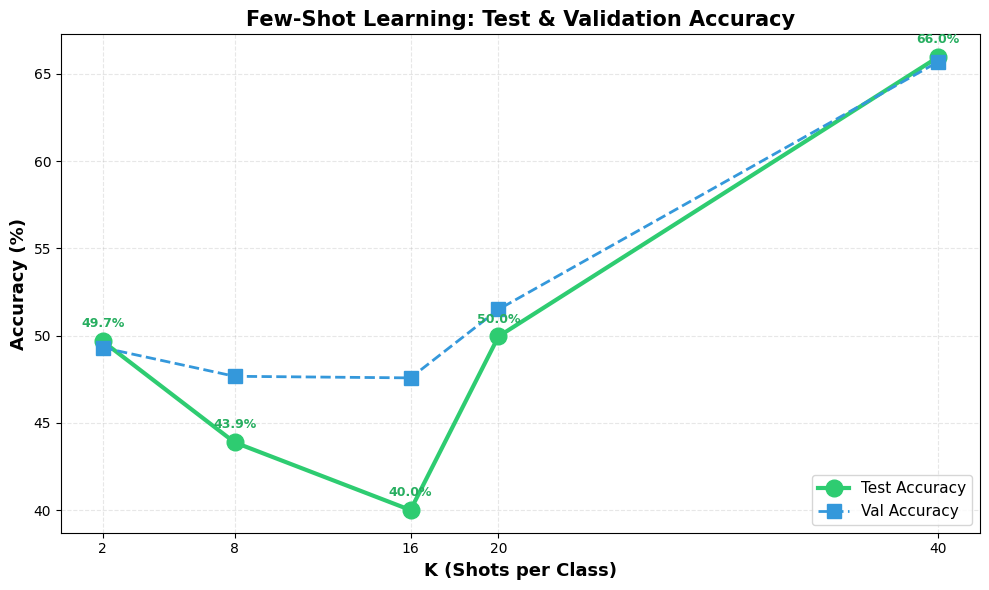

In [ ]:
# Plot 1: Test Accuracy vs K
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(fewshot_results['k_values'], fewshot_results['test_accuracy'], 
        marker='o', linewidth=3, markersize=12, color='#2ecc71', label='Test Accuracy')
ax.plot(fewshot_results['k_values'], fewshot_results['val_accuracy'], 
        marker='s', linewidth=2, markersize=10, color='#3498db', label='Val Accuracy', linestyle='--')

ax.set_xlabel('K (Shots per Class)', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Few-Shot Learning: Test & Validation Accuracy', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='lower right')
ax.set_xticks(fewshot_results['k_values'])

# Annotate points with values
for i, (k, test_acc, val_acc) in enumerate(zip(fewshot_results['k_values'], 
                                                 fewshot_results['test_accuracy'],
                                                 fewshot_results['val_accuracy'])):
    ax.annotate(f'{test_acc:.1f}%', 
                xy=(k, test_acc), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                fontweight='bold',
                color='#27ae60')

plt.tight_layout()
plt.savefig('fewshot_accuracy_comparison.png', dpi=300, bbox_inches='tight')
print(" Accuracy plot saved!")
plt.show()

✓ Sample efficiency plot saved!


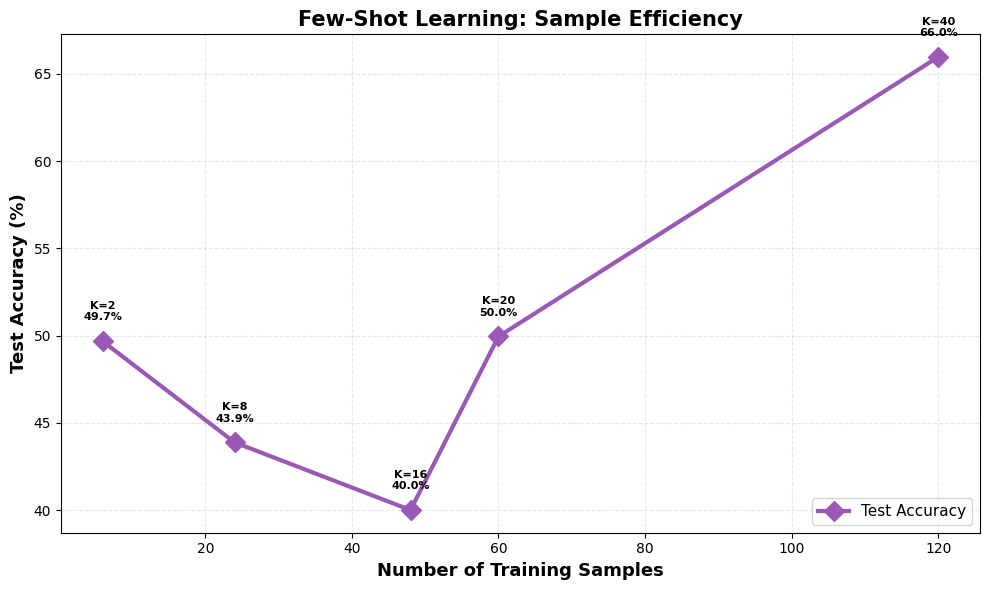

In [ ]:
# Plot 3: Training Samples vs Performance
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(fewshot_results['num_training_samples'], fewshot_results['test_accuracy'], 
        marker='D', linewidth=3, markersize=10, color='#9b59b6', label='Test Accuracy')

ax.set_xlabel('Number of Training Samples', fontsize=13, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Few-Shot Learning: Sample Efficiency', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='lower right')

# Annotate with K values
for i, (samples, acc, k) in enumerate(zip(fewshot_results['num_training_samples'], 
                                           fewshot_results['test_accuracy'],
                                           fewshot_results['k_values'])):
    ax.annotate(f'K={k}\n{acc:.1f}%', 
                xy=(samples, acc), 
                xytext=(0, 15),
                textcoords='offset points',
                ha='center',
                fontsize=8,
                fontweight='bold')

plt.tight_layout()
plt.savefig('fewshot_sample_efficiency.png', dpi=300, bbox_inches='tight')
print(" Sample efficiency plot saved!")
plt.show()

✓ F1-Score plot saved!


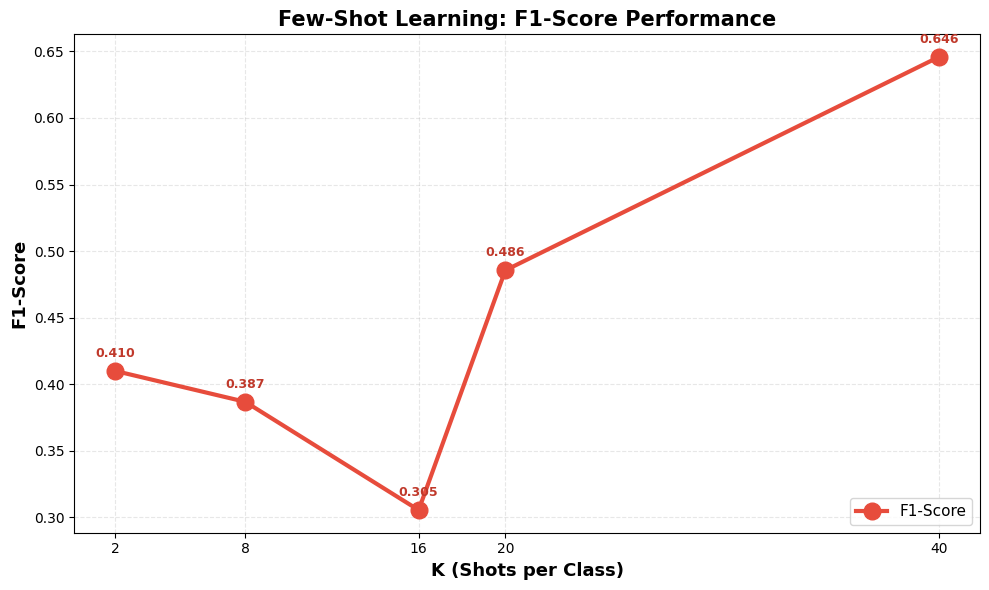

In [58]:
# Plot 2: F1-Score vs K
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(fewshot_results['k_values'], fewshot_results['test_f1'], 
        marker='o', linewidth=3, markersize=12, color='#e74c3c', label='F1-Score')

ax.set_xlabel('K (Shots per Class)', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title('Few-Shot Learning: F1-Score Performance', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='lower right')
ax.set_xticks(fewshot_results['k_values'])

# Annotate points with values
for i, (k, f1) in enumerate(zip(fewshot_results['k_values'], fewshot_results['test_f1'])):
    ax.annotate(f'{f1:.3f}', 
                xy=(k, f1), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                fontweight='bold',
                color='#c0392b')

plt.tight_layout()
plt.savefig('fewshot_f1_comparison.png', dpi=300, bbox_inches='tight')
print("✓ F1-Score plot saved!")
plt.show()

In [59]:
# Analysis: Few-shot learning insights
print("\n" + "="*70)
print("FEW-SHOT LEARNING INSIGHTS")
print("="*70)

# Calculate improvement rate
improvements = []
for i in range(1, len(fewshot_results['test_accuracy'])):
    prev_acc = fewshot_results['test_accuracy'][i-1]
    curr_acc = fewshot_results['test_accuracy'][i]
    improvement = curr_acc - prev_acc
    improvements.append(improvement)
    print(f"K={fewshot_results['k_values'][i-1]} to K={fewshot_results['k_values'][i]}: "
          f"+{improvement:.2f}% accuracy improvement")

print(f"\nAverage improvement per doubling: {np.mean(improvements):.2f}%")

# Compare with full training
full_train_acc = test_acc
best_fewshot_acc = max(fewshot_results['test_accuracy'])
best_k = fewshot_results['k_values'][fewshot_results['test_accuracy'].index(best_fewshot_acc)]

print(f"\nBest few-shot result: K={best_k} with {best_fewshot_acc:.2f}% accuracy")
print(f"Full training result: {full_train_acc:.2f}% accuracy ({len(train_samples)} samples)")
print(f"Gap: {full_train_acc - best_fewshot_acc:.2f}%")
print(f"Efficiency: K={best_k} uses only {best_k * len(label_names)}/{len(train_samples)} "
      f"({best_k * len(label_names) / len(train_samples) * 100:.2f}%) of training data")

# Data efficiency analysis
print(f"\n" + "="*70)
print("DATA EFFICIENCY ANALYSIS")
print(f"="*70)
for k, acc in zip(fewshot_results['k_values'], fewshot_results['test_accuracy']):
    samples = k * len(label_names)
    pct_of_full = samples / len(train_samples) * 100
    acc_ratio = acc / full_train_acc * 100
    print(f"K={k:>2} ({samples:>3} samples, {pct_of_full:>5.2f}% of full): "
          f"{acc:.2f}% accuracy ({acc_ratio:.1f}% of full training performance)")

print("="*70)


FEW-SHOT LEARNING INSIGHTS
K=2 to K=8: +-5.79% accuracy improvement
K=8 to K=16: +-3.88% accuracy improvement
K=16 to K=20: +9.95% accuracy improvement
K=20 to K=40: +16.01% accuracy improvement

Average improvement per doubling: 4.07%

Best few-shot result: K=40 with 65.97% accuracy
Full training result: 65.97% accuracy (9498 samples)
Gap: 0.00%
Efficiency: K=40 uses only 120/9498 (1.26%) of training data

DATA EFFICIENCY ANALYSIS
K= 2 (  6 samples,  0.06% of full): 49.68% accuracy (75.3% of full training performance)
K= 8 ( 24 samples,  0.25% of full): 43.89% accuracy (66.5% of full training performance)
K=16 ( 48 samples,  0.51% of full): 40.01% accuracy (60.7% of full training performance)
K=20 ( 60 samples,  0.63% of full): 49.95% accuracy (75.7% of full training performance)
K=40 (120 samples,  1.26% of full): 65.97% accuracy (100.0% of full training performance)
